# PPI Data Preprocessing

In [ ]:
import pandas as pd

# Load the dataset
file_path = 'dataset_v0.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

# Combine the protein IDs from both columns
protein_ids = pd.concat([data['protein1_uniprotID'], data['protein2_uniprotID']])

# Get unique protein IDs
unique_protein_ids = protein_ids.unique()

# Display the unique protein IDs
data.head()


In [ ]:
data0 = data.drop(columns=['PPI'])
l = []
for i,j in data0.values.tolist():
    l.append(i)
    l.append(j)
len(l)

In [ ]:
import pandas as pd
import time as T
import numpy as np
import csv

t0 = T.time()

def extract_pdb_info(pdb_content):
    atom_types = set()
    chain_identifiers = set()
    atom_info = []
    lines = 0 #to count how many lines of ATOMs
    
    for line in pdb_content:
        if line.startswith('ATOM'):
            lines += 1
            atom_name = line[12:16].strip()
            chain_id = line[21].strip()
            x = float(line[30:38].strip())
            y = float(line[38:46].strip())
            z = float(line[46:54].strip())
            b_factor = float(line[60:66].strip())
            
            atom_types.add(atom_name)
            chain_identifiers.add(chain_id)
            atom_info.append([atom_name, chain_id, x, y, z, b_factor])
    
    return sorted(atom_types), sorted(chain_identifiers), atom_info, lines

# Read the protIDs into list
protID_list = []
file_path = 'dataset_v0.csv'
data = pd.read_csv(file_path)

data = data.drop(columns=['PPI'])
for prot0, prot1 in data.values.tolist():
    protID_list.append(prot0)
    protID_list.append(prot1)

# Read PDB content
ct = 0
for protein_ID in protID_list[0:10000]:
    ct += 1
    if ct % 1000 == 0:
        print(f'>>> Current prot_reading:{ct}/{len(protID_list)}, Time consumed: {T.time()-t0:.2f}s')
    pdb_file_path = f"/home/PPI_test1/pdb_unzip/AF-{protein_ID}-F1-model_v4.pdb"
    with open(pdb_file_path, 'r') as file:
        pdb_content = file.readlines()

    # Extract information
    atom_types, chain_identifiers, atom_info, lines = extract_pdb_info(pdb_content)
    if chain_identifiers != ['A']:
        print(f'The atom types are: {atom_types},\nchain id are: {chain_identifiers},\nlen are: {len(atom_info)} in {lines} lines')
    with open('test_output.csv', 'w', newline='') as csvfile:
        # Create a csv writer object
        csvwriter = csv.writer(csvfile)
        
        # Write each element of the list into the CSV file
        for element in protein_ID:
            csvwriter.writerow([atom_info])  # Write each element as a row
timeconsumed = T.time() - t0
print(f'Total time consumed:{timeconsumed:.2f}s')

print("Data has been written to test_output.csv")

In [ ]:
def get_unique_atom_types(pdb_file):
    atom_types = set()
    
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith('ATOM') or line.startswith('HETATM'):
                atom_name = line[12:16].strip()
                atom_types.add(atom_name)
    
    return sorted(atom_types)

# Get the unique atom types from the provided PDB file
pdb_file_path = "pdb_unzip/AF-Q9Y6R0-F1-model_v4.pdb"  # Replace with the actual path
atom_types = get_unique_atom_types(pdb_file_path)
print(atom_types)


In [ ]:
import numpy as np

def get_unique_atom_types(pdb_file):
    atom_types = set()
    
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith('ATOM') or line.startswith('HETATM'):
                atom_name = line[12:16].strip()
                atom_types.add(atom_name)
    
    return sorted(atom_types)

# Get the unique atom types from the provided PDB file
pdb_file_path = "pdb_unzip/AF-Q9Y6R0-F1-model_v4.pdb"  # Replace with the actual path
atom_types = get_unique_atom_types(pdb_file_path)

# Define atom types for one-hot encoding
atom_type_to_one_hot = {atom: np.eye(len(atom_types))[i] for i, atom in enumerate(atom_types)}

# Function to parse PDB file and extract required information
def parse_pdb(pdb_file):
    atom_data = []
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                atom_name = line[76:78].strip()
                if atom_name in atom_type_to_one_hot:
                    one_hot_encoded_atom = atom_type_to_one_hot[atom_name]
                else:
                    continue  # Skip if atom type is not in our predefined list
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                b_factor = float(line[60:66].strip())
                atom_data.append(np.concatenate([one_hot_encoded_atom, [x, y, z, b_factor]]))
    return np.array(atom_data)

def join_pdb(prot_ID0, prot_ID1):
    # Path to the sample PDB file
    pdb_file_path0 = f'pdb_unzip/AF-{prot_ID0}-F1-model_v4.pdb'
    pdb_file_path1 = f'pdb_unzip/AF-{prot_ID1}-F1-model_v4.pdb'
    # Parse the sample PDB file
    parsed_data0 = parse_pdb(pdb_file_path0)
    parsed_data1 = parse_pdb(pdb_file_path1)
    padded_data0 = np.pad(parsed_data0, ((0, target_shape[0] - parsed_data0.shape[0]), (0, 0)), mode='constant')
    padded_data1 = np.pad(parsed_data1, ((0, target_shape[0] - parsed_data1.shape[0]), (0, 0)), mode='constant')
    #join the 2 numpy arrays
    joined_data = np.stack((padded_data0, padded_data1))
    np.save(f'joined_data_{prot_ID0}_{prot_ID1}.npy', joined_data)
    print(parsed_data0.shape)  # Display the shape for verification
    print(joined_data.shape)
    print(joined_data[1, (4544,41)[0]:, :])  # Print the padded part of parsed_data1
    return joined_data

target_shape = (5000, 41)
joined_data = join_pdb('Q9Y6R0','Q9Y6R0')

In [ ]:
import numpy as np
import pandas as pd

def get_unique_atom_types(pdb_file):
    atom_types = set()
    
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith('ATOM') or line.startswith('HETATM'):
                atom_name = line[12:16].strip()
                atom_types.add(atom_name)
    
    return sorted(atom_types)


# Read the protIDs into list
protID_list = []
file_path = 'dataset_v0.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['Y'])
for prot0, prot1 in data.values.tolist():
    protID_list.append(prot0)
    protID_list.append(prot1)


# Get the unique atom types from the provided PDB file
atom_types = []
for prot_ID in protID_list:
    pdb_file_path = f"pdb_unzip/AF-{prot_ID}-F1-model_v4.pdb"  # Replace with the actual path
    atom_types.append(get_unique_atom_types(pdb_file_path))
max_atom_types = max(atom_types)
print(max_atom_types)

# Generating Sample Data

In [ ]:
# Extract the pattern from 'joined_data'
pattern_shape = joined_data.shape

# Generate 100,000 more random numpy arrays following this pattern
num_samples = 9000
generated_data = np.zeros((num_samples, *pattern_shape))

ct = 0
for n in range(num_samples):
    ct += 1
    if ct % 300 == 0:
        print(f'Generated {ct} / {num_samples}!')
    for i in range(2):  # Both layers for each sample
        num_real_atoms = np.random.randint(3500, 4500)  # Random number of real atoms between 3500 and 4500
        for j in range(num_real_atoms):
            one_hot_index = np.random.randint(0, 37)
            generated_data[n, i, j, one_hot_index] = 1
            generated_data[n, i, j, 37:40] = np.random.rand(3) * 100  # Random coordinates
            generated_data[n, i, j, 40] = np.random.rand() * 100  # Random B-factor

# Stack 'joined_data' with the new generated data
# We should add a new dimension for joined_data to match generated_data dimensions
joined_data_expanded = np.expand_dims(joined_data, axis=0)
final_data = np.vstack((joined_data_expanded, generated_data))

# Save the final data to a file
output_file_path = 'sample_data.npy'
np.save(output_file_path, final_data)

output_file_path


In [ ]:
sample = np.load('sample_data.npy')
sample.shape

In [ ]:
import numpy as np

# Generate 9001 binary labels
np.random.seed(42)
y_labels = np.random.randint(0, 2, 9001)
y_labels.shape

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt

# Load sample data
data = np.load('sample_data.npy')

class ProteinDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Create dataset
dataset = ProteinDataset(data, y_labels)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [50]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(41, 128)
        self.conv2 = GCNConv(128, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 2)  # Binary classification (0 or 1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc1(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

# Assume edge_index is provided or generated (depends on your specific use-case)
# For simplicity, using a dummy edge_index
edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long)

# Initialize model
model = GCN().to('mps')

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(41, 128)
        self.conv2 = GCNConv(128, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 2)  # Binary classification (0 or 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Dummy edge_index and batch for simplicity
edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long)
batch = torch.zeros(data.shape[0], dtype=torch.long)  # Assume a single batch for simplicity

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model = GCN().to(device)

# Training parameters
epochs = 50
learning_rate = 0.01

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data, edge_index.to(device), batch.to(device))
        labels = labels.view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data, edge_index.to(device), batch.to(device))
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(val_loader))
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate on the test set
from sklearn.metrics import classification_report, accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data, edge_index.to(device), batch.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))


# Sample GCN

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.data as pyg_data
import matplotlib.pyplot as plt

# Step 1: Generate 9001 y-labels
y_labels = np.random.randint(0, 2, 9001)

# Step 2: Load the data using PyTorch
sample_data = np.load('sample_data.npy')  # Replace with your actual path

# Check shapes
print("Data shape:", sample_data.shape)
print("Labels shape:", y_labels.shape)

# Convert to PyTorch tensors
X = torch.tensor(sample_data, dtype=torch.float32)
y = torch.tensor(y_labels, dtype=torch.long)

# Split data into training, validation, and testing sets
train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    TensorDataset(X, y), [train_size, val_size, test_size]
)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Step 3: Implement a GCN suitable for the data structure
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 128)
        self.conv2 = pyg_nn.GCNConv(128, 64)
        self.conv3 = pyg_nn.GCNConv(64, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Assuming edges are provided or can be inferred; here, we create a dummy edge_index
num_nodes = sample_data.shape[2]
edge_index = torch.tensor(
    [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
    dtype=torch.long
).t().contiguous()

# Model
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=41, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Step 4: Train the GCN on the data
def train():
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # Flatten the input for GCN
        data = data.view(-1, 41)
        out = model(data, edge_index)
        out = out.view(batch_size, num_nodes, -1).mean(dim=1)  # Average over nodes
        loss = criterion(out, target)
        loss.backward()
        total_loss += loss.item() * data.size(0)
        optimizer.step()
    return total_loss / len(train_loader.dataset)

def validate():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            # Flatten the input for GCN
            data = data.view(-1, 41)
            out = model(data, edge_index)
            out = out.view(batch_size, num_nodes, -1).mean(dim=1)  # Average over nodes
            loss = criterion(out, target)
            total_loss += loss.item() * data.size(0)
    return total_loss / len(val_loader.dataset)

epochs = 20
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    train_loss = train()
    val_loss = validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Step 5: Plot the growth of loss with training epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

# Step 6: Show the prediction results on the test set
def test():
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # Flatten the input for GCN
            data = data.view(-1, 41)
            out = model(data, edge_index)
            out = out.view(batch_size, num_nodes, -1).mean(dim=1)  # Average over nodes
            pred = out.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = correct / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')

test()

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.data as pyg_data
import matplotlib.pyplot as plt

# Step 1: Generate 9001 y-labels
y_labels = np.random.randint(0, 2, 9001)

# Step 2: Load the data using PyTorch
sample_data = np.load('sample_data.npy')  # Replace with your actual path

# Check shapes
print("Data shape:", sample_data.shape)
print("Labels shape:", y_labels.shape)

# Convert to PyTorch tensors
X = torch.tensor(sample_data, dtype=torch.float32)
y = torch.tensor(y_labels, dtype=torch.long)

# Split data into training, validation, and testing sets
train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    TensorDataset(X, y), [train_size, val_size, test_size]
)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
import time
t0 = time.time()

# Step 3: Implement a GCN suitable for the data structure
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 128)
        self.conv2 = pyg_nn.GCNConv(128, 64)
        self.conv3 = pyg_nn.GCNConv(64, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Assuming edges are provided or can be inferred; here, we create a dummy edge_index
num_nodes = 1250
edge_index = torch.tensor(
    [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
    dtype=torch.long
).t().contiguous()

# Model
device = torch.device('mps')
model = GCN(in_channels=41, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Step 4: Train the GCN on the data
def train():
    model.train()
    total_loss = 0
    ct = 0
    for data, target in train_loader:
        while ct<20:
            if ct==98: #skip the last batch
                ct += 1
                # print(f'{ct} DATA SHAPE = {data.shape}\nTARGET SHAPE = {target.shape}')
                print(f'\t\tskipped training batch {ct}...')
            else:
                ct += 1
                # print(f'Now training on batch {ct}!')
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                # Flatten the input for GCN
                data = data.view(-1, 41)
                out = model(data, edge_index.to(device))
                out = out.view(batch_size, num_nodes, -1).mean(dim=1)  # Average over nodes
                loss = criterion(out, target)
                loss.backward()
                total_loss += loss.item() * data.size(0)
                optimizer.step()
                if ct % 10 == 0:
                    print(f'\t\tNow finished batch {ct}!')
    return total_loss / len(train_loader.dataset)

def validate():
    model.eval()
    total_loss = 0
    ct = 0
    with torch.no_grad():
        for data, target in val_loader:
            if ct==14: #skip the last batch
                ct += 1
                # print(f'{ct} DATA SHAPE = {data.shape}\nTARGET SHAPE = {target.shape}')
                print(f'\t\tskipped validation batch {ct}...')
            else:
                ct += 1
                # print(f'Now evaluating on batch {ct}!')
                # print(f'{ct} DATA SHAPE = {data.shape}\nTARGET SHAPE = {target.shape}')
                data, target = data.to(device), target.to(device)
                # Flatten the input for GCN
                data = data.view(-1, 41)
                out = model(data, edge_index.to(device))
                out = out.view(batch_size, num_nodes, -1).mean(dim=1)  # Average over nodes
                loss = criterion(out, target)
                total_loss += loss.item() * data.size(0)
    return total_loss / len(val_loader.dataset)

epochs = 3
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    if epoch != 1:
        t0 = t1
    if epoch == 1:
        t1 = time.time()
        print(f'Time consumed for model loading = {t1-t0:.2f}s')
    print(f'Now training on epoch {epoch}... ...')
    train_loss = train()
    val_loss = validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Training Loss = {train_loss:.4f};\t\tValidation Loss = {val_loss:.4f}')
    t1 = time.time()
    print(f'Time consumed for epoch = {t1-t0:.2f}s')

# Step 5: Plot the growth of loss with training epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

In [ ]:
# Step 6: Show the prediction results on the test set
def test():
    model.eval()
    correct = 0
    ct = 0
    with torch.no_grad():
        for data, target in test_loader:
            ct+=1
            if ct == 29:
                print(f'{ct} DATA SHAPE = {data.shape}\nTARGET SHAPE = {target.shape}')
                print(f'skipped batch {ct}...')
            else:
                data, target = data.to(device), target.to(device)
                # Flatten the input for GCN
                data = data.view(-1, 41)
                out = model(data, edge_index.to(device))
                sample = np.random.randint(0,2,1)
                print(ct, out.shape, out[sample])
                out = out.view(batch_size, num_nodes*8, -1)  # Average over nodes
                print(ct, out.shape)
                out = out.mean(dim=1)
                print(ct, out.shape)
                pred = out.argmax(dim=1)
                print(ct, out.shape, out[sample], pred)
                correct += pred.eq(target).sum().item()
    accuracy = correct / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy*100:.4f}%')

test()

In [ ]:
num_nodes,

In [ ]:
import torch

# 假设输入张量的形状
out = torch.randn(640000, 2)

# 定义 batch_size 和 num_nodes
batch_size = 64
num_nodes = 2

# 计算第三个维度
total_elements = out.numel()  # 总元素数量
remaining_dimension = -1

# 重塑张量
reshaped_out = out.view(batch_size, num_nodes, remaining_dimension)
print("Reshaped tensor shape:", reshaped_out.shape)


# Obtaining atom count and visualizing count dist.

In [ ]:
import numpy as np
import pandas as pd
import time
t0 = time.time()

def get_unique_atom_types(pdb_file):
    atom_types = set()
    
    with open(pdb_file, 'r') as file:
        line_ct = 0
        for line in file:
            if line.startswith('ATOM') or line.startswith('HETATM'):
                line_ct += 1
                atom_name = line[12:16].strip()
                atom_types.add(atom_name)
    
    line_list.append(line_ct)
    return sorted(atom_types)


# Read the protIDs into list
protID_list = []
file_path = 'dataset_v0.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['Y'])
for prot0, prot1 in data.values.tolist():
    protID_list.append(prot0)
    protID_list.append(prot1)


# Get the unique atom types from the provided PDB file
atom_types = set()
line_list = []
for prot_ID in protID_list:
    pdb_file_path = f"pdb_unzip/AF-{prot_ID}-F1-model_v4.pdb"  # Replace with the actual path
    atom_types.update(get_unique_atom_types(pdb_file_path))
line_list = sorted(line_list)

print(atom_types)
print(f"Max lines: {max(line_list)}, Min lines: {min(line_list)}")
print(f"Time consumed: {time.time()-t0:.2f}")

In [ ]:
import matplotlib.pyplot as plt

# Assuming your list of integers is named 'data'
data = line_list

# Generate the x-axis values
x_values = range(1, len(data) + 1)

# Create the bar plot
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.bar(x_values, data)

# Set y-axis limit starting from zero
plt.ylim(0, max(data) * 1.1)  # Adding some margin above the max value for better visualization

# Set titles and labels
plt.title('Bar Graph of Integer Data')
plt.xlabel('Index')
plt.ylabel('Value')

# Show the plot
plt.show()

In [ ]:
x_values = range(1, len(data) + 1)
x_values

In [ ]:
import matplotlib.pyplot as plt

start = 0
end = 500
# Assuming your list of integers is named 'data'
data = line_list[start:end]

# Generate the x-axis values
x_values = range(1, len(data)+1)

print(len(x_values),len(data))
# Create the bar plot
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.bar(x_values, data)

# Set y-axis limit starting from zero
plt.ylim(0, max(data) * 1.1)  # Adding some margin above the max value for better visualization

# Set titles and labels
plt.title('Bar Graph of Integer Data')
plt.xlabel('Index')
plt.ylabel('Value')

# Show the plot
plt.show()

In [ ]:
line_list[0]

# Analysis: probability distribution graph & clustering

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming your list is named 'line_list'

# Step 1: Count the frequency of each element in the list
element_counts = Counter(line_list)

# Step 2: Calculate the total number of elements in the list
total_elements = len(line_list)

# Step 3: Calculate the probability of each element
probability_distribution = {element: count / total_elements for element, count in element_counts.items()}

# Prepare data for plotting
elements = list(probability_distribution.keys())
probabilities = list(probability_distribution.values())

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(elements, probabilities, color='skyblue')
plt.xlim([0,3000])
# Set titles and labels
plt.title('Probability Distribution of Elements in Line List')
plt.xlabel('Elements')
plt.ylabel('Probability')

# Show the plot
plt.show()


## Clustering on Length

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans

# Assuming your list is named 'line_list'

# Step 1: Count the frequency of each element in the list
element_counts = Counter(line_list)

# Step 2: Calculate the total number of elements in the list
total_elements = len(line_list)

# Step 3: Calculate the probability of each element
probability_distribution = {element: count / total_elements for element, count in element_counts.items()}

# Prepare data for clustering using the x-axis indices
elements = list(probability_distribution.keys())
x_indices = np.array(range(len(elements))).reshape(-1, 1)

# Perform K-means clustering
num_clusters = 24  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(x_indices)
labels = kmeans.labels_

# Define 12 distinct colors
colors = [
    'red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 
    'black', 'brown', 'pink', 'grey'
]

# Plot the original distribution with cluster color-coding
plt.figure(figsize=(18, 6))

for i in range(num_clusters):
    cluster_elements = np.array(elements)[labels == i]
    cluster_probabilities = np.array(list(probability_distribution.values()))[labels == i]
    plt.bar(cluster_elements, cluster_probabilities, color=colors[i % len(colors)], label=f'Cluster {i+1}')

# Set titles and labels
plt.xlim([0,3000])
plt.title('Clustered Probability Distribution of Elements in Line List')
plt.xlabel('Elements')
plt.ylabel('Probability')
plt.legend()

# Show the plot
plt.show()


## Clustering on PrDist

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.cluster import AgglomerativeClustering

# Assuming your list is named 'line_list'

# Step 1: Count the frequency of each element in the list
element_counts = Counter(line_list)

# Step 2: Calculate the total number of elements in the list
total_elements = len(line_list)

# Step 3: Calculate the probability of each element
probability_distribution = {element: count / total_elements for element, count in element_counts.items()}

# Prepare data for clustering
elements = list(probability_distribution.keys())
probabilities = np.array(list(probability_distribution.values())).reshape(-1, 1)

# Perform Agglomerative Clustering
num_clusters = 12  # Number of clusters
clustering = AgglomerativeClustering(n_clusters=num_clusters)
labels = clustering.fit_predict(probabilities)

# Define 12 distinct colors
colors = [
    'red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 
    'black', 'brown', 'pink', 'grey'
]

# Plot the original distribution with cluster color-coding
plt.figure(figsize=(12, 6))

for i in range(num_clusters):
    cluster_elements = np.array(elements)[labels == i]
    cluster_probabilities = probabilities[labels == i]
    plt.bar(cluster_elements, cluster_probabilities.flatten(), color=colors[i % len(colors)], label=f'Cluster {i+1}')

# Set titles and labels
plt.xlim([0,3000])
plt.title('Clustered Probability Distribution of Elements in Line List')
plt.xlabel('Elements')
plt.ylabel('Probability')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Dummy dataset
x = torch.randn(100000, 10)  # 1000 samples, 10 features each
y = torch.randint(0, 2, (100000,))  # 1000 binary labels
dataset = TensorDataset(x, y)
train_loader = DataLoader(dataset, batch_size=9, shuffle=True)

# Simple model
model = nn.Sequential(nn.Linear(10, 50), nn.ReLU(), nn.Linear(50, 2))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with progress bar
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}",ncols=120)
    
    for inputs, labels in progress_bar:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(train_loader))

    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.data as pyg_data
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt


# Step 1: Load the y-labels
y_labels = np.load('data_y_label_0629.npy')


# Step 2: Load the data using PyTorch
sample_data = np.load('data_zero_padding.npy')

#Shuffle
indices = np.random.permutation(len(sample_data))
sample_data = sample_data[indices]
y_labels = y_labels[indices]

# Check shapes
print("Data shape:", sample_data.shape)
print("Labels shape:", y_labels.shape, y_labels[0])

# Convert to PyTorch tensors
X = torch.tensor(sample_data, dtype=torch.float32)
y = torch.tensor(y_labels, dtype=torch.long)

# Split data into training, validation, and testing sets
train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    TensorDataset(X, y), [train_size, val_size, test_size]
)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
import time
import torch
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from tqdm.auto import tqdm

# Initialize some variables
t0 = time.time()

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 128)
        self.conv2 = pyg_nn.GCNConv(128, 64)
        self.conv3 = pyg_nn.GCNConv(64, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Assuming edges are provided or can be inferred; here, we create a dummy edge_index
num_nodes = 546
edge_index = torch.tensor(
    [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
    dtype=torch.long
).t().contiguous()

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=41, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

# Define DataLoader
# Assuming train_loader and val_loader are already defined with appropriate batch_size

# Train function
def train(epoch_pbar):
    model.train()
    total_loss = 0
    ct = 0
    TP = FP = TN = FN = 0
    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch_pbar.n + 1}", ncols=120, leave=False) as progress_bar:
        for data, target in train_loader:
            t_batch = time.time()
            try:
                ct += 1
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                # Flatten the input for GCN
                data = data.view(-1, 41)
                out = model(data, edge_index.to(device))
                out = out.view(batch_size, -1, 2).mean(dim=1)  # Average over nodes
                loss = criterion(out, target)
                loss.backward()
                total_loss += loss.item() * data.size(0)
                optimizer.step()

                pred = out.argmax(dim=1)
                TP += ((pred == 1) & (target == 1)).sum().item()
                TN += ((pred == 0) & (target == 0)).sum().item()
                FP += ((pred == 1) & (target == 0)).sum().item()
                FN += ((pred == 0) & (target == 1)).sum().item()

                progress_bar.set_postfix(loss=total_loss / (ct * batch_size))
                progress_bar.update(1)
            except Exception as e:
                if "]' is invalid for input of size" in str(e):
                    print("\tTraining Phase finished!")
                else:
                    print(f'\tBatch {ct}: {e}')

    precision = (TP / (TP + FP) * 100) if (TP + FP) > 0 else 0.0
    recall = (TP / (TP + FN) * 100) if (TP + FN) > 0 else 0.0
    accuracy = ((TP + TN) / (TP + TN + FP + FN) * 100) if (TP + TN + FP + FN) > 0 else 0.0

    return total_loss / len(train_loader.dataset), precision, recall, accuracy

# Validate function
def validate(epoch_pbar):
    model.eval()
    total_loss = 0
    ct = 0
    TP = FP = TN = FN = 0
    with tqdm(total=len(val_loader), desc=f"Validation Epoch {epoch_pbar.n + 1}", ncols=120, leave=False) as progress_bar:
        with torch.no_grad():
            for data, target in val_loader:
                t_batch = time.time()
                try:
                    ct += 1
                    data, target = data.to(device), target.to(device)
                    # Flatten the input for GCN
                    data = data.view(-1, 41)
                    out = model(data, edge_index.to(device))
                    out = out.view(batch_size, -1, 2).mean(dim=1)  # Average over nodes
                    loss = criterion(out, target)
                    total_loss += loss.item() * data.size(0)

                    pred = out.argmax(dim=1)
                    TP += ((pred == 1) & (target == 1)).sum().item()
                    TN += ((pred == 0) & (target == 0)).sum().item()
                    FP += ((pred == 1) & (target == 0)).sum().item()
                    FN += ((pred == 0) & (target == 1)).sum().item()

                    progress_bar.set_postfix(loss=total_loss / (ct * batch_size))
                    progress_bar.update(1)
                except Exception as e:
                    if "]' is invalid for input of size" in str(e):
                        print("\tValidation Phase finished!")
                    else:
                        print(f'\tBatch {ct}: {e}')

    precision = (TP / (TP + FP) * 100) if (TP + FP) > 0 else 0.0
    recall = (TP / (TP + FN) * 100) if (TP + FN) > 0 else 0.0
    accuracy = ((TP + TN) / (TP + TN + FP + FN) * 100) if (TP + TN + FP + FN) > 0 else 0.0

    return total_loss / len(val_loader.dataset), precision, recall, accuracy

train_losses = []
val_losses = []
start = 0

# Run function
def run(epochs):
    global start, t0
    end = start + epochs
    with tqdm(total=epochs, desc="Total Progress", ncols=120) as epoch_pbar:
        for epoch in range(start + 1, end + 1):
            t0 = time.time()
            print(f'Now training on epoch {epoch}/{end} ... ...')
            train_loss, train_precision, train_recall, train_accuracy = train(epoch_pbar)
            val_loss, val_precision, val_recall, val_accuracy = validate(epoch_pbar)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            t1 = time.time()

            # Print metrics in a table format
            print(f'+{"-"*117}+')
            print(f'| {"Epoch":^6} | {"Train Loss":^12} | {"Val Loss":^12} | {"Train Precision":^15} | {"Val Precision":^15} | {"Train Recall":^12} | {"Val Recall":^12} | {"Train Acc":^10} | {"Val Acc":^10} |')
            print(f'+{"-"*117}+')
            print(f'| {epoch:^6} | {train_loss:^12.4f} | {val_loss:^12.4f} | {train_precision:^15.2f}% | {val_precision:^15.2f}% | {train_recall:^12.2f}% | {val_recall:^12.2f}% | {train_accuracy:^10.2f}% | {val_accuracy:^10.2f}% |')
            print(f'+{"-"*117}+')
            print(f'Time consumed = {t1-t0:.2f}s\n')

            epoch_pbar.update(1)
            
        start += epochs

# Call the run function for a given number of epochs
# For example, run(10) to train and validate for 10 epochs


In [ ]:
run(3)

In [ ]:
from tqdm import tqdm

def test():
    global test_batches
    model.eval()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    ct = 0
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing", ncols=100)
        for data, target in progress_bar:
            print('Target =', target.shape, target)
            ct += 1
            
            try:
                data, target = data.to(device), target.to(device)
                # Flatten the input for GCN
                data = data.view(-1, 41)
                out = model(data, edge_index.to(device))
                sample = np.random.randint(0, 2, 1)
                # print('Out =', ct, out.shape, out[sample])
                out = out.view(batch_size, -1, 2)  # Adjust shape for model output
                # print('Out =', ct, out.shape)
                out = out.mean(dim=1)
                # print('Out =', ct, out.shape, out[sample])
                pred = out.argmax(dim=1)
                print('Pred', ct, '=', pred.shape, pred)
                
                # Calculate true positives and false positives
                TP += ((pred == 1) & (target == 1)).sum().item()
                TN += ((pred == 0) & (target == 0)).sum().item()
                FP += ((pred == 1) & (target == 0)).sum().item()
                FN += ((pred == 0) & (target == 1)).sum().item()
            except Exception as e:
                print(f'skipped batch {ct} due to error: {e}')
    
    # Calculate precision
    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0.0
    
    print(f'+-------------------------------+\n| TP\t| FP\t| TN\t| FN\t|\n+-------+-------+-------+-------+\n| {TP}\t| {FP}\t| {TN}\t| {FN}\t|\n+-------------------------------+')
    print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN) * 100:.2f}%\tRecall: {TP / (TP + FN) * 100:.2f}%\tSpecificity: {TN / (TN + FP) * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%\tNegative: {TN / (TN + FN) * 100:.2f}%')

# Call the test function
test()


In [ ]:
import numpy as np
import threading
import time
from tqdm import tqdm

# Function to simulate progress
def load_data_with_progress(file_path):
    # Start the progress bar
    progress = tqdm(total=100, desc="Loading Data")

    # Define a function that simulates progress
    def update_progress():
        while not load_event.is_set():
            progress.update(1)
            time.sleep(0.05)  # Adjust the speed of progress updates if necessary

    # Create an event to signal the end of loading
    load_event = threading.Event()

    # Start the progress thread
    progress_thread = threading.Thread(target=update_progress)
    progress_thread.start()

    # Load the data
    data = np.load(file_path)

    # Stop the progress bar
    load_event.set()
    progress_thread.join()
    progress.close()

    return data

# Load the data with a progress bar
sample_data = load_data_with_progress('data_zero_padding.npy')

# STRING dataset

In [1]:
import pandas as pd

In [ ]:
string = pd.read_csv('raw_data/protein.actions.STRING.txt', sep='\s+')
string.set_option('display.max_rows', 100)
string.head(100)

# CrossVal Plot

In [ ]:
### GCNN bs ==64
Train_Losses = [0.06421659141778946, 0.023606065660715103, 0.02277509495615959, 0.02250279113650322, 0.022522516548633575, 0.02239418402314186, 0.022415779531002045, 0.022461647167801857, 0.02239142544567585, 0.022404663264751434, 0.02238146960735321, 0.02243015728890896, 0.02235705405473709, 0.02229229360818863, 0.022509252652525902, 0.022632837295532227, 0.022332534193992615]
Train_Accuracies = [86.46261182692848, 95.75198334552411, 97.50182861644066, 98.10386541382996, 98.29516682608451, 98.42457660496258, 98.52022731108985, 98.57086592021605, 98.5933719687166, 98.58774545659146, 98.5933719687166, 98.5933719687166, 98.6271310414674, 98.63838406571766, 98.60462499296686, 98.59899848084173, 98.610251505092]
Val_Losses = [0.04474035992033622, 0.02703090107758317, 0.024236107382381505, 0.019439296285357167, 0.01950652683481827, 0.019063255253857637, 0.018870877160769794, 0.018837908506787307, 0.018807123581457537, 0.018780077773730183, 0.018763766331417183, 0.018767788134949264, 0.01876629150295542, 0.01876646961408524, 0.01876582250394696, 0.01876594737345239, 0.018766244898758794]
Val_Accuracies = [94.44194419441945, 96.82718271827183, 97.14221422142214, 97.83978397839785, 97.72727272727273, 97.83978397839785, 97.83978397839785, 97.86228622862286, 97.9072907290729, 97.9072907290729, 97.9072907290729, 97.9072907290729, 97.9072907290729, 97.9072907290729, 97.9072907290729, 97.9072907290729, 97.9072907290729]
# min_val_los 0.018763766331417183 for epoch 10 ............... best_val_accurac 97.9072907290729 for epoch 8

import matplotlib.pyplot as plt

# Assuming the data from the image provided
epochs = list(range(1, 18))

# Plotting Train and Validation Losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, Train_Losses, label='Train Loss')
plt.plot(epochs, Val_Losses, label='Validation Loss')
plt.title('Train & Validation Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Train and Validation Accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, Train_Accuracies, label='Train Accuracy')
plt.plot(epochs, Val_Accuracies, label='Validation Accuracy')
plt.title('Train & Validation Accuracies vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import turtle
import random
import time

# --- Game Setup ---
screen = turtle.Screen()
screen.setup(600, 400)
screen.title("Super Snake!")
screen.bgcolor("black")
screen.tracer(0) # Turns off screen updates

screen_width = screen.window_width()  # Get the width of the screen
screen_height = screen.window_height() # Get the height of the screen

# --- Functions ---
def move_snake():
  global snake_x, snake_y

  if direction == 'up':
    snake_y += 20
  elif direction == 'down':
    snake_y -= 20
  elif direction == 'left':
    snake_x -= 20
  elif direction == 'right':
    snake_x += 20

  snake.goto(snake_x, snake_y)

def create_food():
    global food_x, food_y
    food_x = random.randint(-screen_width // 2 + 10, screen_width // 2 - 10)
    food_y = random.randint(-screen_height // 2 + 10, screen_height // 2 - 10)
    food.goto(food_x, food_y)

def chase():
    global monster_x, monster_y
    # Simple chasing logic: move the monster towards the snake
    if monster_x < snake_x:
        monster_x += 5
    elif monster_x > snake_x:
        monster_x -= 5

    if monster_y < snake_y:
        monster_y += 5
    elif monster_y > snake_y:
        monster_y -= 5

    monster.goto(monster_x, monster_y)



# --- Game Variables ---
snake_x = 0
snake_y = 0
direction = 'right' # Initial direction of the snake


food_x = random.randint(-screen_width // 2 + 10, screen_width // 2 - 10)
food_y = random.randint(-screen_height // 2 + 10, screen_height // 2 - 10)

monster_x = random.randint(-screen_width // 2 + 10, screen_width // 2 - 10)
monster_y = random.randint(-screen_height // 2 + 10, screen_height // 2 - 10)


# --- Turtle Setup ---

snake = turtle.Turtle()
snake.speed(0) # Fastest animation speed
snake.shape("square")
snake.color("green")
snake.penup()  
snake.goto(snake_x, snake_y)

food = turtle.Turtle()
food.speed(0)
food.shape("circle")
food.color("red")
food.penup() 
create_food() # Place the food initially

monster = turtle.Turtle()
monster.speed(0)
monster.shape("triangle")
monster.color("purple")
monster.penup()  
monster.goto(monster_x, monster_y)



# --- Keyboard Bindings ---
screen.listen()
screen.onkeypress(lambda: set_direction('up'), 'Up')
screen.onkeypress(lambda: set_direction('down'), 'Down')
screen.onkeypress(lambda: set_direction('left'), 'Left')
screen.onkeypress(lambda: set_direction('right'), 'Right')

def set_direction(new_direction):
    global direction 
    direction = new_direction

# --- Game Loop ---
start_time = time.time() # Record the start time

while True:
  screen.update()

  move_snake()

  chase()

  if snake.distance(food) < 20:
    create_food()

  if snake.distance(monster) < 20:
    end_time = time.time()
    print("Game Over!")
    print("Time:", round(end_time - start_time, 2), "seconds")
    break

turtle.done()


In [8]:
l = set()
if l:
    print(1)

# Check Redundancy

In [ ]:
from collections import defaultdict

def find_duplicate_pairs(file_path):
    pair_dict = defaultdict(lambda: {'count': 0, 'lines': [], 'labels': set()})
    label_count = defaultdict(int)  # Initialize for counting '0' and '1' labels
    unique_pairs = defaultdict(set)

    with open(file_path, 'r') as file:
        header = next(file)  # Skip the header line
        for line_number, line in enumerate(file, start=2):  # Start from 2 to account for the header
            parts = line.strip().split()
            if len(parts) < 8:  # Ensure we have enough columns
                continue  # Skip malformed lines

            col1, col2 = parts[0], parts[1]
            # Normalize the pair to handle both (col1, col2) and (col2, col1)
            pair = tuple(sorted([col1, col2]))

            # Track the count of labels if there are any specific labels
            # In this case, we are not given labels in the provided snippet, so we'll skip this

            # Track unique pairs
            unique_pairs['all'].add(pair)

            # Track pair information for duplicates
            pair_info = pair_dict[pair]
            pair_info['count'] += 1
            pair_info['lines'].append(line_number)

    # Filter and format results
    results = []
    total_redundant_lines = 0
    for pair, info in pair_dict.items():
        if info['count'] > 1:
            total_redundant_lines += (info['count'] - 1)  # Count of redundant lines

            results.append({
                'pair': pair,
                'occurred_times': info['count'],
                'occurred_lines': info['lines']
            })

    # Print results
    if results:
        print("Duplicate pairs found:")
        for result in results:
            pair = result['pair']
            occurred_times = result['occurred_times']
            occurred_lines = result['occurred_lines']
            print(f"Pair: {pair}, Occurred Times: {occurred_times}, Occurred Lines: {occurred_lines}")
        print(f"Total Redundant Lines: {total_redundant_lines}")
    else:
        print("No duplicate pairs found.")

    # Print the number of unique rows
    unique_row_count = len(unique_pairs['all'])
    print(f"\nNumber of unique rows: {unique_row_count}")

# Example usage:
file_path = 'positive_sample_protein_less300.txt'
find_duplicate_pairs(file_path)

In [ ]:
from collections import defaultdict

def find_duplicate_pairs(file_path):
    pair_dict = defaultdict(lambda: {'count': 0, 'lines': [], 'labels': set()})
    label_count = {'0': 0, '1': 0}
    unique_pairs = {'0': set(), '1': set()}

    with open(file_path, 'r') as file:
        next(file)  # Skip the header line
        for line_number, line in enumerate(file, start=2):  # Start from 2 to account for the header
            parts = line.strip().split()
            if len(parts) != 3:
                continue  # Skip malformed lines

            id1, id2, y = parts
            pair = tuple(sorted([id1, id2]))  # Sort the pair to handle both {ID_A, ID_B} and {ID_B, ID_A}

            # Track total label counts
            label_count[y] += 1

            # Track unique pairs for each label (store sorted pairs)
            unique_pairs[y].add(pair)

            # Track pair information for duplicates
            pair_info = pair_dict[pair]
            pair_info['count'] += 1
            pair_info['lines'].append(line_number)
            pair_info['labels'].add(y)  # Track all labels for this pair

    # Categorize and filter results
    category_0 = []
    category_1 = []
    category_01 = []
    total_redundant_lines = 0
    total_redundant_lines_0 = 0
    total_redundant_lines_1 = 0
    total_redundant_lines_01 = 0

    for pair, info in pair_dict.items():
        if info['count'] > 1:
            total_redundant_lines += (info['count'] - 1)  # Count of redundant lines
            
            if len(info['labels']) == 1:
                label = info['labels'].pop()  # All labels are the same
                if label == '0':
                    category_0.append({
                        'pair': pair,
                        'occurred_times': info['count'],
                        'occurred_lines': info['lines']
                    })
                    total_redundant_lines_0 += (info['count'] - 1)
                elif label == '1':
                    category_1.append({
                        'pair': pair,
                        'occurred_times': info['count'],
                        'occurred_lines': info['lines']
                    })
                    total_redundant_lines_1 += (info['count'] - 1)
            else:
                first_label = '0' if '0' in info['labels'] else '1'
                if '0' in info['labels'] and '1' in info['labels']:
                    category_01.append({
                        'pair': pair,
                        'label': 'X' if first_label == '0' else 'Y',
                        'occurred_times': info['count'],
                        'occurred_lines': info['lines']
                    })
                    total_redundant_lines_01 += (info['count'] - 1)

    # Print results
    print(f"Total Redundant Lines: {total_redundant_lines}")

    if category_0:
        print("\nCategory 1 - All Redundancies with Label = 0:")
        for result in category_0:
            pair = result['pair']
            occurred_times = result['occurred_times']
            occurred_lines = result['occurred_lines']
            print(f"Pair: {pair}, Occurred Times: {occurred_times}, Occurred Lines: {occurred_lines}")
        print(f"Total Redundant Lines for Label 0: {total_redundant_lines_0}")
    else:
        print("\nCategory 1 - No redundancies with Label = 0.")

    if category_1:
        print("\nCategory 2 - All Redundancies with Label = 1:")
        for result in category_1:
            pair = result['pair']
            occurred_times = result['occurred_times']
            occurred_lines = result['occurred_lines']
            print(f"Pair: {pair}, Occurred Times: {occurred_times}, Occurred Lines: {occurred_lines}")
        print(f"Total Redundant Lines for Label 1: {total_redundant_lines_1}")
    else:
        print("\nCategory 2 - No redundancies with Label = 1.")

    if category_01:
        print("\nCategory 3 - Redundancies with both Labels 0 and 1:")
        for result in category_01:
            pair = result['pair']
            label = result['label']
            occurred_times = result['occurred_times']
            occurred_lines = result['occurred_lines']
            print(f"Pair: {pair}, Label: {label}, Occurred Times: {occurred_times}, Occurred Lines: {occurred_lines}")
        print(f"Total Redundant Lines for both Labels 0 and 1: {total_redundant_lines_01}")
    else:
        print("\nCategory 3 - No redundancies with both Labels 0 and 1.")

    # Print the total number of 1 and 0 labels and the number of unique 1 and 0 rows
    total_0_labels = label_count['0']
    total_1_labels = label_count['1']
    unique_0_rows = len(unique_pairs['0'])
    unique_1_rows = len(unique_pairs['1'])

    print(f"\nTotal number of '0' labels: {total_0_labels}")
    print(f"Total number of '1' labels: {total_1_labels}")
    print(f"Number of unique '0' rows: {unique_0_rows}")
    print(f"Number of unique '1' rows: {unique_1_rows}")

    print(f"Total Redundant Lines for Label 0: {total_redundant_lines_0}")
    print(f"Total Redundant Lines for Label 1: {total_redundant_lines_1}")
    print(f"Total Redundant Lines for both Labels 0 and 1: {total_redundant_lines_01}")

# Example usage:
file_path = 'dataset_nored.txt'
find_duplicate_pairs(file_path)

# Create NoRed Dataset

In [1]:
def extract_unique_pairs(file_path, output_path):
    ct = 0
    unique_pairs = set()

    with open(file_path, 'r') as file:
        header = next(file)  # Skip the header line
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:  # Ensure we have at least two columns
                continue  # Skip malformed lines

            col1, col2 = parts[0], parts[1]
            # Normalize the pair to handle both (col1, col2) and (col2, col1)
            pair = tuple(sorted([col1, col2]))

            # Add the unique pair to the set
            unique_pairs.add(pair)

    # Write the unique pairs to the new file
    with open(output_path, 'w') as out_file:
        for pair in unique_pairs:
            ct+=1
            out_file.write(f"{pair[0]}\t{pair[1]}\t1\n")

    print(f"Unique pairs have been written to {output_path}",ct)

# Example usage:
input_file_path = 'positive_sample_protein_less300.txt'
output_file_path = 'dataset_nored.txt'
extract_unique_pairs(input_file_path, output_file_path)

Unique pairs have been written to dataset_nored.txt 47640


## Append Negative data

In [2]:
def load_existing_pairs(output_file_path):
    existing_pairs = set()
    with open(output_file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:  # Ensure we have at least two columns
                continue  # Skip malformed lines
            col1, col2 = parts[0], parts[1]
            pair = tuple(sorted([col1, col2]))
            existing_pairs.add(pair)
    return existing_pairs

def extract_negative_pairs(input_file_path, output_file_path):
    existing_pairs = load_existing_pairs(output_file_path)
    unique_negative_pairs = set()

    with open(input_file_path, 'r') as file:
        header = next(file)  # Skip the header line
        for line in file:
            parts = line.strip().split()
            if len(parts) < 3:  # Ensure we have at least three columns
                continue  # Skip malformed lines

            col1, col2, label = parts[0], parts[1], parts[2]

            # Process only negative data (where label is '0')
            if label == '0':
                pair = tuple(sorted([col1, col2]))

                # Only add if the pair is not in the existing pairs set
                if pair not in existing_pairs:
                    unique_negative_pairs.add(pair)

    # Append unique negative pairs to the output file
    with open(output_file_path, 'a') as out_file:
        for pair in unique_negative_pairs:
            out_file.write(f"{pair[0]}\t{pair[1]}\t0\n")

    print(f"Unique negative pairs that were not already in {output_file_path} have been appended.")

# Example usage:
input_file_path = 'protein.actions.OWN.txt'
output_file_path = 'dataset_nored.txt'
extract_negative_pairs(input_file_path, output_file_path)

Unique negative pairs that were not already in dataset_nored.txt have been appended.


# 长短蛋白测试集

### to txt

In [3]:
import random

# 定义文件路径
input_file = "human_PPI_string_20240505.txt"
output_file = "LS_Hm_50k.txt"

# 读取原始数据集
with open(input_file, "r") as file:
    lines = file.readlines()

# 随机选择10000行
random.seed(42)  # 保证结果可复现
selected_lines = random.sample(lines, 100000)

def process(columns,linect,label):
    global ct
    if 'Name' in columns[0] or 'To' in columns[1]:
        ct += 1
    else:
        try:
            
            new_line = f"{columns[0]}\t{columns[1]}\t{label}\n"  # 只保留col1, col2，添加col3为整数1
            linect += 1
            file.write(new_line)
            return linect
        except Exception as e:
            ct += 1
            # print(e)
            print(f'Encoutered "To" exception, count = {ct}')

# 创建新数据集并写入文件
with open(output_file, "w") as file:
    ct = 0
    posct = 0
    negct = 0
    for line in selected_lines:
        columns = line.strip().split("\t")  # 分割列
        try:
            if int(columns[4]) > 0 and int(columns[5]) > 0 and posct < 2500:
                posct = process(columns,posct,1)

            if int(columns[4]) == 0 and int(columns[5]) == 0 and negct < 2500:
                negct = process(columns,negct,0)
            else:
                print(columns)
            if posct == 2500 and negct == 2500:
                break

            
        except Exception as e:
            # print(f'\n{e}')
            # print(columns)
            # print(columns[0])
            pass

print(f"已成功生成新的数据集，文件名为: {output_file}")

['P12830', 'Q9UBC0', '882', '465', '0', '50', '0', '0']
['P01106', 'O43818', '454', '475', '161', '0', '0', '0']
['Q9NTI5', 'P68431', '1447', '136', '0', '129', '0', '0']
['Q9UNX3', 'Q86YB7', '145', '292', '0', '162', '0', '0']
['O76054', 'Q9UM47', '403', '2321', '0', '71', '0', '0']
['Q8N423', 'Q9UNI1', '598', '258', '0', '113', '0', '0']
['Q92604', 'Q12866', '370', '999', '0', '49', '0', '154']
['Q96RP8', 'Q8NC44', '456', '543', '0', '174', '0', '0']
['O43347', 'Q9BYD2', '362', '267', '192', '0', '0', '0']
['Q9NUI1', 'Q8NCF5', '292', '419', '0', '113', '0', '0']
['Q9UJX2', 'Q96B97', '597', '665', '292', '0', '0', '0']
['O00548', 'O95477', '723', '2261', '0', '70', '0', '0']
['Q92482', 'Q8TDI7', '292', '906', '0', '109', '0', '0']
['P31314', 'P61371', '330', '349', '0', '104', '0', '0']
['P55769', 'Q15388', '128', '145', '0', '66', '0', '0']
['P13688', 'P42574', '526', '277', '0', '76', '0', '0']
['O14607', 'Q5T1H1', '1444', '3165', '0', '161', '0', '0']
['Q8N9W6', 'Q13610', '295', '5

### to npy

In [ ]:
import numpy as np
import random

# 定义文件路径
input_file = "human_PPI_string_20240505.txt"
output_file = "longshort_test.npy"

# 读取原始数据集
with open(input_file, "r") as file:
    lines = file.readlines()

# 随机选择10000行
random.seed(42)  # 设置随机种子以保证结果可复现
selected_lines = random.sample(lines, 10000)

# 初始化新数据集的数组
new_data = np.zeros((10000, 7), dtype=object)
ct = 0
row2del = []
# 处理选中的每一行
for i, line in enumerate(selected_lines):
    try:
        columns = line.strip().split("\t")  # 分割列
        if 'Name' in columns[0] or 'Name' in columns[1]:
            row2del.append(i)

        # print('columns[4], columns[5]',columns[4], columns[5])
        if int(columns[4]) != 0 and int(columns[5]) != 0:
            # print('============================================================================')
            new_data[i, 6] = 1  # col7为整数1
            new_data[i, 2] = columns[0]  # col3为原来的col1
            new_data[i, 5] = columns[1]  # col6为原来的col2
        elif int(columns[4]) == 0 and int(columns[5]) == 0:
            # print('++++++++++++++++++++++++++++++++++++++++')
            new_data[i, 6] = 0  # col7为整数0
            new_data[i, 2] = columns[0]  # col3为原来的col1
            new_data[i, 5] = columns[1]  # col6为原来的col2
        else:
            row2del.append(i)

    except:
        ct += 1
        print(f'Encoutered "To" exception, count = {ct}')
        row2del.append(i)

new_data = np.delete(new_data,row2del,axis=0)
# 保存为npy文件
np.save(output_file, new_data)

print(f"已成功生成新的npy数据集，文件名为: {output_file}")

print(new_data.shape)
print('>>>1:',np.sum(new_data[:,6] == 1))
print('>>>0:',np.sum(new_data[:,6] == 0))


In [ ]:
data = np.load(output_file,allow_pickle=True)
print(data.shape)
indices_to_delete = [i for i in range(len(data)) if len(data[i][2]) != 6 or len(data[i][5]) != 6]
data = np.delete(data, indices_to_delete, axis=0)
print(data.shape)
data = data[0:500]
print(data.shape)

np.save(output_file, data)


# Dataset Investing

### PPI_GNN Dataset

In [4]:
import numpy as np
def check(data):
    ones = np.where((data[:, 6] == 1) | (data[:, 6] == '1'))[0]
    num1 = len(ones)
    print(f'Ones = {num1}  |  1 at line = {ones[:25]}')
    zeros = np.where((data[:, 6] == 0) | (data[:, 6] == '0'))[0]
    num0 = len(zeros)
    print(f'Zeros = {num0}  |  0 at line = {zeros[:25]}')
    print(f'Ratios:\t>1:  {(num1/(num1+num0))*100:2f}%       >0:  {(num0/(num1+num0))*100:2f}%')

    print(f'Dataset shape = {data.shape}')
    print(f'Dataset head = \n{data[:-1]}')

In [2]:
### 100k 1:1 split Short Prot dataset

actions_dataset_own = np.load('actions_own_dataset_no_red.npy',allow_pickle=True)
print(f'Loaded Dataset {actions_dataset_own.shape}')
check(actions_dataset_own)

Loaded Dataset (100712, 7)
Ones = 47579  |  1 at line = [    0     1     2 ... 47576 47577 47578]
Zeros = 53133  |  0 at line = [ 47579  47580  47581 ... 100709 100710 100711]
Ratios:
	>1:  47.242632%       >0:  52.757368%
Dataset shape = 
(100712, 7)
Dataset head = 
[[0 0 'P63000' ... 0 'Q9Y241' 1]
 [0 0 'Q13242' ... 0 'Q8N488' 1]
 [0 0 'Q99623' ... 0 'Q9NQ48' 1]
 ...
 [0 0 'P27105' ... 0 'Q9NY35' 0]
 [0 0 'Q8NHZ8' ... 0 'Q9P0N9' 0]
 [0 0 'P62263' ... 0 'P62318' 0]]


In [3]:
# 22k Original Paper Dataset

actions_dataset_human = np.load('npy_file_new(human_dataset).npy',allow_pickle=True)
print(f'Loaded Dataset {actions_dataset_human.shape}')
check(actions_dataset_human)

Loaded Dataset (22217, 7)
Ones = 16220  |  1 at line = [    0     1     2 ... 16217 16218 22216]
Zeros = 5997  |  0 at line = [16219 16220 16221 ... 22213 22214 22215]
Ratios:
	>1:  73.007157%       >0:  26.992843%
Dataset shape = 
(22217, 7)
Dataset head = 
[['NP_663777' 'Q13114' '1FLK' ... 'P26842' '5TL5' '1']
 ['NP_003630' 'Q9Y6K9' '2JVX' ... 'Q14790' '1F9E' '1']
 ['NP_003001' 'P45985' '3ALN' ... 'Q12852' '5CEN' '1']
 ...
 ['P10619' 'P10619' '1IVY' ... 'P49368' '6NR8' '0']
 ['NP_000779' 'P27707' '1P5Z' ... 'P00338' '1I10' '0']
 ['NP_008828' 'P31274' '2LP0' ... 'Q9H257' '6E25' '0']]


In [1]:
with open('human_PPI_string_20240505.txt','r') as file:
    lines = file.readlines()

length_dict = {}
anom_idx = []
name_idx = []

for i,line in enumerate(lines):
    col = line.strip().split("\t")
    if 'Name' in col[0]:
        name_idx.append(i)
    else:
        try:
            length_dict[col[0]] = col[2]
            length_dict[col[1]] = col[3]
        except Exception as e:
            # print(e)
            anom_idx.append(i)

print(f'Anomoly Lines = {len(anom_idx)}')
print(f'Name Lines = {len(name_idx)}')

Anomoly Lines = 79375
Name Lines = 24886


Prot Not Found = 4023
Prot  Less 300 = 1,115 of 4,162   (22,217 Lines of Data)
Ratio Less 300 = 26.79 %
Average Length = 644.07


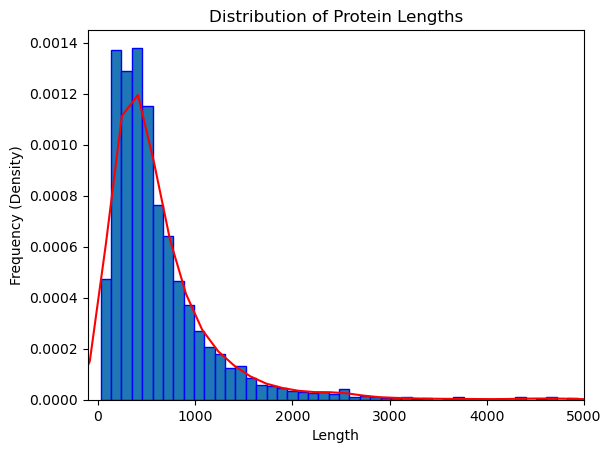

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze(dataset,uplim=30000,bins=500):
    less300 = []
    protlength = []
    prot_notfound = []
    prot_set = set()

    for col in [1,2,4,5]:
        for prot in dataset[:,col]:
            prot_set.add(prot)

    for prot in prot_set:
        try:
            protlength.append(int(length_dict[prot]))
            if int(length_dict[prot]) < 300:
                less300.append(prot)
        except Exception as e:
            # print(e)
            prot_notfound.append(prot)
    print(f'Prot Not Found = {len(prot_notfound)}')
    print(f'Prot  Less 300 = {len(less300):,} of {len(protlength):,}   ({len(dataset):,} Lines of Data)')
    print(f'Ratio Less 300 = {len([x for x in protlength if x < 300]) / len(protlength)*100:.2f} %')
    print(f'Average Length = {sum(protlength) / len(protlength):,.2f}')

    ### Histogram of Lengths
    plt.xlim([-100,uplim])
    plt.hist(protlength, bins=bins, edgecolor='blue', density=True)
    plt.xlabel('Length')
    plt.ylabel('Frequency (Density)')
    plt.title(f'Distribution of Protein Lengths')
    ### PDF approximation
    sns.kdeplot(protlength, fill=False, color='red')
    plt.show()

    # plt.hist([x for x in protlength if x < 300], bins=80, edgecolor='blue', density=True)
    # plt.xlabel('Length')
    # plt.ylabel('Frequency (Density)')
    # plt.title(f'Distribution of Protein Lengths')
    # plt.xlim([-20,320])
    # plt.show()
    # print([x for x in protlength if x < 300])

analyze(actions_dataset_human,5000,300)

Prot Not Found = 1
Prot  Less 300 = 4,298 of 4,298   (100,712 Lines of Data)
Ratio Less 300 = 100.00 %
Average Length = 197.58


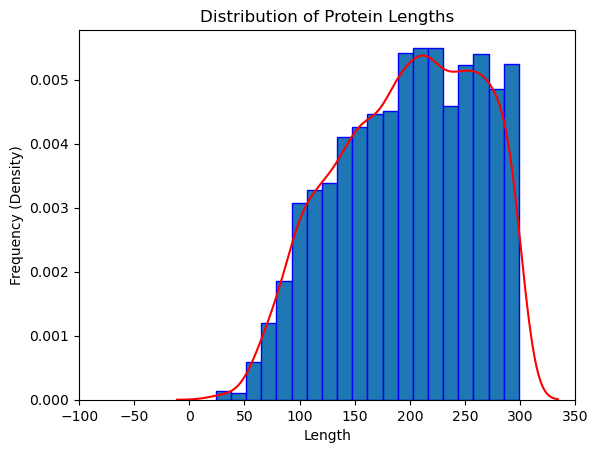

In [30]:
analyze(actions_dataset_own,uplim=350,bins=20)

In [149]:
import numpy as np

# 定义筛选条件函数
def filter_protein_lengths(dataset, length_dict, max_length=300):
    filtered_data = []
    prot_notfound = []
    for row in dataset:
        protein1 = row[1]  # 第二列是第一个蛋白质名称
        protein2 = row[4]  # 第五列是第二个蛋白质名称
        
        try:
            length1 = int(length_dict[protein1])
            length2 = int(length_dict[protein2])
            
            # 检查两个蛋白质长度是否都小于max_length
            if length1 < max_length and length2 < max_length:
                filtered_data.append(row)
        
        except Exception as e:
            # 捕捉不在 length_dict 中的蛋白质名称
            prot_notfound.append(e)
    print(f'Not found: {len(prot_notfound)}')
    return np.array(filtered_data)

# 使用函数筛选数据
filtered_dataset = filter_protein_lengths(actions_dataset_human, length_dict)
# 输出筛选后的数据集
print(actions_dataset_human.shape)
print(filtered_dataset[-432*2:].shape)
np.save('npy_file_short(human_dataset)',filtered_dataset[-432*2:])

Not found: 332
(22217, 7)
(864, 7)


### 制作S GNN

In [176]:
actions_dataset_human27 = np.concatenate((actions_dataset_own[:1600-1295],filtered_dataset))
check(actions_dataset_human27)
np.save('npy_file_short27(human_dataset)',actions_dataset_human27)

Ratios:
	>1:  73.000000%       >0:  27.000000%
Dataset shape = 
(1600, 7)
Dataset head = 
[[0 0 'P63000' ... 0 'Q9Y241' 1]
 [0 0 'Q13242' ... 0 'Q8N488' 1]
 [0 0 'Q99623' ... 0 'Q9NQ48' 1]
 ...
 ['NP_005312' 'P10412' '3TZD' ... 'P07451' '1Z93' '0']
 ['NP_004119' 'P13984' '1BBY' ... 'P09936' '2ETL' '0']
 ['NP_000371' 'P23025' '1D4U' ... 'P00441' '1AZV' '0']]


### 制作LS GNN

In [180]:
check(actions_dataset_human)

Ones = 16220  |  1 at line = [    0     1     2 ... 16217 16218 22216]
Zeros = 5997  |  0 at line = [16219 16220 16221 ... 22213 22214 22215]
Ratios:
	>1:  73.007157%       >0:  26.992843%
Dataset shape = 
(22217, 7)
Dataset head = 
[['NP_663777' 'Q13114' '1FLK' ... 'P26842' '5TL5' '1']
 ['NP_003630' 'Q9Y6K9' '2JVX' ... 'Q14790' '1F9E' '1']
 ['NP_003001' 'P45985' '3ALN' ... 'Q12852' '5CEN' '1']
 ...
 ['P10619' 'P10619' '1IVY' ... 'P49368' '6NR8' '0']
 ['NP_000779' 'P27707' '1P5Z' ... 'P00338' '1I10' '0']
 ['NP_008828' 'P31274' '2LP0' ... 'Q9H257' '6E25' '0']]


In [187]:
np.random.seed(42)
# Number of samples to pick
num_pos_samples = 1168
num_neg_samples = 432
# Split the dataset into positive and negative samples
pos_samples = actions_dataset_human[:16218]
neg_samples = actions_dataset_human[16218:22215]

# Randomly select the required number of positive and negative samples
selected_pos = pos_samples[np.random.choice(pos_samples.shape[0], num_pos_samples, replace=False)]
selected_neg = neg_samples[np.random.choice(neg_samples.shape[0], num_neg_samples, replace=False)]

# Combine the selected samples to form the new dataset
LS_GNN1600 = np.vstack((selected_pos, selected_neg))

# Optionally, you can shuffle the new dataset to mix pos and neg samples
np.random.shuffle(LS_GNN1600)

# LS_GNN1600 is now your new dataset
np.save('npy_file_LS_GNN1600', LS_GNN1600)

### LS Hm 1k 1:1

In [2]:
len(lines),actions_dataset_own.shape

NameError: name 'actions_dataset_own' is not defined

In [7]:
import random
random.seed(42)

LS_Hm_1000_11 = np.zeros([1000,7])
LS_Hm_1000_11 = LS_Hm_1000_11.astype(object)
anom_idx, name_idx = [], []
data_ct, one_ct, zero_ct = 0, 0, 0

shuffled_Hm = lines[:]
random.shuffle(shuffled_Hm)
print('shuffled_Hm !')

shuffled_Hm !


In [8]:
for i,line in enumerate(shuffled_Hm):
    col = line.strip().split("\t")
    if 'Name' in col[0]:
        name_idx.append(i)
    else:
        try:
            # print(int(col[4]))

            if zero_ct < 500 and int(col[4]) == 0 and int(col[5]) == 0:
                
                LS_Hm_1000_11[data_ct,2] = col[0]
                LS_Hm_1000_11[data_ct,5] = col[1]
                LS_Hm_1000_11[data_ct,6] = 0
                zero_ct += 1
                data_ct += 1
            if one_ct < 500 and int(col[4]) > 0 and int(col[5]) > 0:
                LS_Hm_1000_11[data_ct,2] = col[0]
                LS_Hm_1000_11[data_ct,5] = col[1]
                LS_Hm_1000_11[data_ct,6] = 1
                one_ct += 1
                data_ct += 1
            
            if data_ct == 1000:
                print('Done !')
                break
            if data_ct % 100 == 1:
                print(data_ct,LS_Hm_1000_11[data_ct-1])


        except Exception as e:
            # print(i)
            # print(e)
            anom_idx.append(i)

1 [0.0 0.0 'P17693' 0.0 0.0 'P04626' 0]
101 [0.0 0.0 'Q9NZS2' 0.0 0.0 'P22749' 0]
201 [0.0 0.0 'Q9HAT1' 0.0 0.0 'P49286' 0]
301 [0.0 0.0 'Q14515' 0.0 0.0 'O75829' 0]
301 [0.0 0.0 'Q14515' 0.0 0.0 'O75829' 0]
301 [0.0 0.0 'Q14515' 0.0 0.0 'O75829' 0]
401 [0.0 0.0 'P10243' 0.0 0.0 'Q15645' 0]
401 [0.0 0.0 'P10243' 0.0 0.0 'Q15645' 0]
401 [0.0 0.0 'P10243' 0.0 0.0 'Q15645' 0]
501 [0.0 0.0 'O14672' 0.0 0.0 'Q01094' 0]
501 [0.0 0.0 'O14672' 0.0 0.0 'Q01094' 0]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O60260' 1]
601 [0.0 0.0 'Q96RE7' 0.0 0.0 'O6026

In [9]:
check(LS_Hm_1000_11)

Ones = 500  |  1 at line = [ 13  56  81  97  99 141 143 152 159 212 218 260 270 295 297 334 350 358
 416 437 482 485 514 523 524 525 526 527 528 529 530 531 532 533 534 535
 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553
 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571
 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589
 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607
 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643
 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661
 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679
 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697
 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715
 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733
 734 735 736 737 738 739

In [10]:
np.save('LS_Hm_1000_11', LS_Hm_1000_11)

### LS Hm 50k 1:1

In [12]:
import random
random.seed(42)

LS_Hm_50k_11 = np.zeros([50000,7])
LS_Hm_50k_11 = LS_Hm_50k_11.astype(object)
anom_idx, name_idx = [], []
data_ct, one_ct, zero_ct = 0, 0, 0

shuffled_Hm = lines[:]
random.shuffle(shuffled_Hm)
print('shuffled_Hm !')

for i,line in enumerate(shuffled_Hm):
    col = line.strip().split("\t")
    if 'Name' in col[0]:
        name_idx.append(i)
    else:
        try:
            # print(int(col[4]))

            if zero_ct < 25000 and int(col[4]) == 0 and int(col[5]) == 0:
                
                LS_Hm_50k_11[data_ct,2] = col[0]
                LS_Hm_50k_11[data_ct,5] = col[1]
                LS_Hm_50k_11[data_ct,6] = 0
                zero_ct += 1
                data_ct += 1
            if one_ct < 25000 and int(col[4]) > 0 and int(col[5]) > 0:
                LS_Hm_50k_11[data_ct,2] = col[0]
                LS_Hm_50k_11[data_ct,5] = col[1]
                LS_Hm_50k_11[data_ct,6] = 1
                one_ct += 1
                data_ct += 1
            
            if data_ct == 50000:
                print('Done !')
                break
            if data_ct % 100 == 1:
                print(data_ct,LS_Hm_50k_11[data_ct-1])


        except Exception as e:
            # print(i)
            # print(e)
            anom_idx.append(i)

shuffled_Hm !
1 [0.0 0.0 'P17693' 0.0 0.0 'P04626' 0]
101 [0.0 0.0 'Q9NZS2' 0.0 0.0 'P22749' 0]
201 [0.0 0.0 'Q9HAT1' 0.0 0.0 'P49286' 0]
301 [0.0 0.0 'Q14515' 0.0 0.0 'O75829' 0]
301 [0.0 0.0 'Q14515' 0.0 0.0 'O75829' 0]
301 [0.0 0.0 'Q14515' 0.0 0.0 'O75829' 0]
401 [0.0 0.0 'P10243' 0.0 0.0 'Q15645' 0]
401 [0.0 0.0 'P10243' 0.0 0.0 'Q15645' 0]
401 [0.0 0.0 'P10243' 0.0 0.0 'Q15645' 0]
501 [0.0 0.0 'O14672' 0.0 0.0 'Q01094' 0]
501 [0.0 0.0 'O14672' 0.0 0.0 'Q01094' 0]
601 [0.0 0.0 'P31152' 0.0 0.0 'Q9H093' 0]
601 [0.0 0.0 'P31152' 0.0 0.0 'Q9H093' 0]
701 [0.0 0.0 'O43447' 0.0 0.0 'Q9BV57' 0]
701 [0.0 0.0 'O43447' 0.0 0.0 'Q9BV57' 0]
801 [0.0 0.0 'P20366' 0.0 0.0 'P04141' 0]
801 [0.0 0.0 'P20366' 0.0 0.0 'P04141' 0]
801 [0.0 0.0 'P20366' 0.0 0.0 'P04141' 0]
801 [0.0 0.0 'P20366' 0.0 0.0 'P04141' 0]
901 [0.0 0.0 'P51648' 0.0 0.0 'Q9H2A2' 0]
1001 [0.0 0.0 'Q9NYA4' 0.0 0.0 'Q9Y2L5' 0]
1001 [0.0 0.0 'Q9NYA4' 0.0 0.0 'Q9Y2L5' 0]
1101 [0.0 0.0 'O00442' 0.0 0.0 'P07902' 0]
1201 [0.0 0.0 'Q6X4

In [13]:
check(LS_Hm_50k_11)

Ones = 25000  |  1 at line = [   13    56    81 ... 49997 49998 49999]
Zeros = 25000  |  0 at line = [    0     1     2 ... 26146 26147 26148]
Ratios:
	>1:  50.000000%       >0:  50.000000%
Dataset shape = 
(50000, 7)
Dataset head = 
[[0.0 0.0 'P17693' ... 0.0 'P04626' 0]
 [0.0 0.0 'Q9NPF5' ... 0.0 'P12074' 0]
 [0.0 0.0 'Q9P000' ... 0.0 'Q9NXR5' 0]
 ...
 [0.0 0.0 'P42858' ... 0.0 'Q13002' 1]
 [0.0 0.0 'P30101' ... 0.0 'O94972' 1]
 [0.0 0.0 'Q9UPN4' ... 0.0 'Q92600' 1]]


In [14]:
np.save('LS_Hm_50k_11',LS_Hm_50k_11)

### S Hm 1k 1:1

In [23]:
import random
random.seed(42)

num_samples = 1000

S_Hm_1k_11 = np.zeros([num_samples,7])
S_Hm_1k_11 = S_Hm_1k_11.astype(object)
anom_idx, name_idx = [], []
data_ct, one_ct, zero_ct = 0, 0, 0

shuffled_Hm = lines[:]
random.shuffle(shuffled_Hm)
print('shuffled_Hm !')

for i,line in enumerate(shuffled_Hm):
    col = line.strip().split("\t")
    if 'Name' in col[0]:
        name_idx.append(i)
    else:
        try:
            # print(int(col[4]))

            if int(col[2]) <= 300 and int(col[3]) <= 300 and zero_ct < num_samples/2 and int(col[4]) == 0 and int(col[5]) == 0:
                
                S_Hm_1k_11[data_ct,2] = col[0]
                S_Hm_1k_11[data_ct,5] = col[1]
                S_Hm_1k_11[data_ct,6] = 0
                zero_ct += 1
                data_ct += 1
            if int(col[2]) <= 300 and int(col[3]) <= 300 and one_ct < num_samples/2 and int(col[4]) > 0 and int(col[5]) > 0:
                S_Hm_1k_11[data_ct,2] = col[0]
                S_Hm_1k_11[data_ct,5] = col[1]
                S_Hm_1k_11[data_ct,6] = 1
                one_ct += 1
                data_ct += 1
            
            if data_ct == num_samples:
                print('Done !')
                break
            if data_ct % 100 == 1:
                print(data_ct,S_Hm_1k_11[data_ct-1])


        except Exception as e:
            # print(i)
            # print(e)
            anom_idx.append(i)

shuffled_Hm !
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
1 [0.0 0.0 'P45973' 0.0 0.0 'P84103' 0]
101 [0.0 0.0 'P24385' 0.0 0.0 'P01298' 0]
101 [0.0 0.0 'P24385' 0.0 0.0 'P01298' 0]
101 [0.0 0.0 'P24385' 0.0 0.0 'P01298' 0]
101 [0.0 0.0 'P24385' 0.0 0.0 'P01298' 0]
101 [0.0 0.0 'P24385' 0.0 0.0 'P01298' 0]
101 [0.0 0.0 'P24385' 0.0 0.0 'P01298' 0]
101 [0.0 0.0 'P24385' 0.0 0.0 'P01298' 0]
101 [0.0 0.0 'P24385' 0.0 0.0 'P01298' 0]
101 [0.0 0.0 'P24385' 0.0 0.0 'P01298' 0]
101 [0.0 0.0 'P24385' 0.0 0.0 'P01298' 0]
101 [0

In [25]:
check(S_Hm_1k_11)

Ones = 500  |  1 at line = [ 13  19  74 139 143 169 176 182 203 206 211 225 239 260 261 290 303 305
 315 321 328 334 382 487 488 504 522 527 528 529 530 531 532 533 534 535
 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553
 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571
 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589
 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607
 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625
 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643
 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661
 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679
 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697
 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715
 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733
 734 735 736 737 738 739

In [26]:
np.save('S_Hm_1k_11',S_Hm_1k_11)

### S Hm 10k 1:1

In [32]:
import random
random.seed(42)

num_samples = 10000

S_Hm_10k_11 = np.zeros([num_samples,7])
S_Hm_10k_11 = S_Hm_10k_11.astype(object)
anom_idx, name_idx = [], []
data_ct, one_ct, zero_ct = 0, 0, 0

shuffled_Hm = lines[:]
random.shuffle(shuffled_Hm)
print('shuffled_Hm !')

for i,line in enumerate(shuffled_Hm):
    col = line.strip().split("\t")
    if 'Name' in col[0]:
        name_idx.append(i)
    else:
        try:
            # print(int(col[4]))

            if int(col[2]) <= 300 and int(col[3]) <= 300 and zero_ct < num_samples/2 and int(col[4]) == 0 and int(col[5]) == 0:
                
                S_Hm_10k_11[data_ct,2] = col[0]
                S_Hm_10k_11[data_ct,5] = col[1]
                S_Hm_10k_11[data_ct,6] = 0
                zero_ct += 1
                data_ct += 1
            if int(col[2]) <= 300 and int(col[3]) <= 300 and one_ct < num_samples/2 and int(col[4]) > 0 and int(col[5]) > 0:
                S_Hm_10k_11[data_ct,2] = col[0]
                S_Hm_10k_11[data_ct,5] = col[1]
                S_Hm_10k_11[data_ct,6] = 1
                one_ct += 1
                data_ct += 1
            
            if data_ct == num_samples:
                print('Done !')
                break
            # if data_ct % 100 == 1:
            #     print(data_ct,S_Hm_10k_11[data_ct-1])


        except Exception as e:
            # print(i)
            # print(e)
            anom_idx.append(i)

shuffled_Hm !
Done !


In [33]:
check(S_Hm_10k_11)

Ones = 5000  |  1 at line = [  13   19   74 ... 9997 9998 9999]
Zeros = 5000  |  0 at line = [   0    1    2 ... 5298 5299 5300]
Ratios:
	>1:  50.000000%       >0:  50.000000%
Dataset shape = 
(10000, 7)
Dataset head = 
[[0.0 0.0 'P45973' ... 0.0 'P84103' 0]
 [0.0 0.0 'P05019' ... 0.0 'P01562' 0]
 [0.0 0.0 'P19388' ... 0.0 'O75608' 0]
 ...
 [0.0 0.0 'P13073' ... 0.0 'P58546' 1]
 [0.0 0.0 'Q9Y291' ... 0.0 'Q14197' 1]
 [0.0 0.0 'Q8N183' ... 0.0 'O95169' 1]]


In [34]:
np.save('S_Hm_10k_11',S_Hm_10k_11)

### LS Hm 10k 1:1

In [37]:
import random
random.seed(42)

num_samples = 10000

LS_Hm_10k_11 = np.zeros([num_samples,7])
LS_Hm_10k_11 = LS_Hm_10k_11.astype(object)
anom_idx, name_idx = [], []
data_ct, one_ct, zero_ct = 0, 0, 0

shuffled_Hm = lines[:]
random.shuffle(shuffled_Hm)
print('shuffled_Hm !')

for i,line in enumerate(shuffled_Hm):
    col = line.strip().split("\t")
    if 'Name' in col[0]:
        name_idx.append(i)
    else:
        try:
            # print(int(col[4]))

            if zero_ct < num_samples/2 and int(col[4]) == 0 and int(col[5]) == 0:
                
                LS_Hm_10k_11[data_ct,2] = col[0]
                LS_Hm_10k_11[data_ct,5] = col[1]
                LS_Hm_10k_11[data_ct,6] = 0
                zero_ct += 1
                data_ct += 1
            if one_ct < num_samples/2 and int(col[4]) > 0 and int(col[5]) > 0:
                LS_Hm_10k_11[data_ct,2] = col[0]
                LS_Hm_10k_11[data_ct,5] = col[1]
                LS_Hm_10k_11[data_ct,6] = 1
                one_ct += 1
                data_ct += 1
            
            if data_ct == num_samples:
                print('Done !')
                break
            # if data_ct % 100 == 1:
            #     print(data_ct,LS_Hm_10k_11[data_ct-1])


        except Exception as e:
            # print(i)
            # print(e)
            anom_idx.append(i)

shuffled_Hm !
Done !


In [38]:
check(LS_Hm_10k_11)

Ones = 5000  |  1 at line = [  13   56   81 ... 9997 9998 9999]
Zeros = 5000  |  0 at line = [   0    1    2 ... 5216 5217 5218]
Ratios:
	>1:  50.000000%       >0:  50.000000%
Dataset shape = 
(10000, 7)
Dataset head = 
[[0.0 0.0 'P17693' ... 0.0 'P04626' 0]
 [0.0 0.0 'Q9NPF5' ... 0.0 'P12074' 0]
 [0.0 0.0 'Q9P000' ... 0.0 'Q9NXR5' 0]
 ...
 [0.0 0.0 'P10599' ... 0.0 'P35222' 1]
 [0.0 0.0 'Q96CA5' ... 0.0 'O43464' 1]
 [0.0 0.0 'Q15744' ... 0.0 'P18847' 1]]


In [39]:
np.save('LS_Hm_10k_11',LS_Hm_10k_11)

# Dataset Phase 2 (Week 10)

### NPY dataset to TXT

In [ ]:
import numpy as np

file_head = 'LS_Hm_1k_11'

data = np.load(f'{file_head}.npy',allow_pickle=True)

# Extract prot1 (col 3), prot2 (col 6), and label (col 7) columns
prot1 = data[:, 2]  # Indexing starts from 0, so col 3 is index 2
prot2 = data[:, 5]  # Col 6 is index 5
label = data[:, 6]  # Col 7 is index 6

# Open the output text file
with open(f'{file_head}.txt', 'w') as f:
    # Write each row in the format: prot1\tprot2\tlabel
    for p1, p2, lbl in zip(prot1, prot2, label):
        f.write(f"{p1}\t{p2}\t{int(lbl)}\n")  # Convert label to int to ensure it's 1 or 0

# Generating 1~10k Datasets

### 定义函数

In [2]:
### Load the whole original file to variable "lines"

with open('human_PPI_string_20240505.txt','r') as file:
    lines = file.readlines()

length_dict = {}
anom_idx = []
name_idx = []

for i,line in enumerate(lines):
    col = line.strip().split("\t")
    if 'Name' in col[0]:
        name_idx.append(i)
    else:
        try:
            length_dict[col[0]] = col[2]
            length_dict[col[1]] = col[3]
        except Exception as e:
            # print(e)
            anom_idx.append(i)

print(f'Anomoly Lines = {len(anom_idx)}')
print(f'Name Lines = {len(name_idx)}')

Anomoly Lines = 79375
Name Lines = 24886


In [21]:
### Define 2 main functions

import random
import numpy as np


def generate(sample_size, length_mode, ran_seed=42, exclude_short=False, exclude_seed=42):
    """
    Main function to generate dataset from original file
    """
    random.seed(ran_seed)
    num_samples = int(sample_size*1000)

    dataset = np.zeros([num_samples,7])
    dataset = dataset.astype(object)
    anom_idx, name_idx = [], []
    data_ct, one_ct, zero_ct = 0, 0, 0

    shuffled_Hm = lines[:]
    random.shuffle(shuffled_Hm)
    # print('shuffled_Hm !')

    for i,line in enumerate(shuffled_Hm):
        print(line)
        col = line.strip().split("\t")
        if 'Name' in col[0]:
            name_idx.append(i)
        else:
            # try:
                # print(int(col[4]))
                # int(col[2]) <= 300 and int(col[3]) <= 300 and 

                ### Wether to exclude short for finetune LS dataset
            if exclude_short != False:
                lines2exclude = np.load(f'S_Hm_{exclude_short}k_seed{exclude_seed}_11.npy', allow_pickle=True)
                pairs2exclude = set()
                line_ct = 0
                while line_ct <= len(lines2exclude):
                    print(line)
                    prot1, prot2 = line[2], line[5]
                    prot_pair = sorted((prot1,prot2))
                    prot_pair = tuple(prot_pair)
                    pairs2exclude.add(prot_pair)
                    print("Now on pair/set:",prot_pair,pairs2exclude)
                    line_ct += 1
                    
            else:
                lines2exclude = None

            if length_mode == 'LS':

                current_pair = set((col[0],col[1]))     # Set the current pair as a set for validation
                
                if zero_ct < num_samples/2 and int(col[4]) == 0 and int(col[5]) == 0 and current_pair not in pairs2exclude:
                    dataset[data_ct,2] = col[0]
                    dataset[data_ct,5] = col[1]
                    dataset[data_ct,6] = 0
                    zero_ct += 1
                    data_ct += 1
                if one_ct < num_samples/2 and int(col[4]) > 0 and int(col[5]) > 0 and line not in pairs2exclude:
                    dataset[data_ct,2] = col[0]
                    dataset[data_ct,5] = col[1]
                    dataset[data_ct,6] = 1
                    one_ct += 1
                    data_ct += 1
                
                if data_ct == num_samples:
                    print(f'\n\n>>>>>>> Done with LS_{sample_size}_seed{ran_seed}!')
                    break
                # if data_ct % 100 == 1:
                #     print(data_ct,dataset[data_ct-1])

            elif length_mode == 'S':
                if int(col[2]) <= 300 and int(col[3]) <= 300 and zero_ct < num_samples/2 and int(col[4]) == 0 and int(col[5]) == 0:
                    dataset[data_ct,2] = col[0]
                    dataset[data_ct,5] = col[1]
                    dataset[data_ct,6] = 0
                    zero_ct += 1
                    data_ct += 1
                if int(col[2]) <= 300 and int(col[3]) <= 300 and one_ct < num_samples/2 and int(col[4]) > 0 and int(col[5]) > 0:
                    dataset[data_ct,2] = col[0]
                    dataset[data_ct,5] = col[1]
                    dataset[data_ct,6] = 1
                    one_ct += 1
                    data_ct += 1
                
                if data_ct == num_samples:
                    print(f'\n\n>>>>>>> Done with S_{sample_size}_seed{ran_seed}!')
                    break
            
            else:
                print('>>> !!! ERROR !!! <<<')

            # except Exception as e:
            #     # print(i)
            #     print(e)
            #     anom_idx.append(i)

    check(dataset)

    if exclude_short != False:
        np.save(f'finetune{length_mode}_Hm_{sample_size}k_seed{ran_seed}_11',dataset)
    else:
        np.save(f'{length_mode}_Hm_{sample_size}k_seed{ran_seed}_11',dataset)

def check(data):
    """
    Check shape and ratio of dataset generated
    """
    ones = np.where((data[:, 6] == 1) | (data[:, 6] == '1'))[0]
    num1 = len(ones)
    print(f'Ones = {num1}  |  1 at line = {ones[:25]}')
    zeros = np.where((data[:, 6] == 0) | (data[:, 6] == '0'))[0]
    num0 = len(zeros)
    print(f'Zeros = {num0}  |  0 at line = {zeros[:25]}')
    print(f'Ratios:\t>1:  {(num1/(num1+num0))*100:2f}%       >0:  {(num0/(num1+num0))*100:2f}%')

    print(f'Dataset shape = {data.shape}')
    print(f'Dataset head = \n{data[:-1]}')

In [92]:
seed_ct = 1

while seed_ct <= 4:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 0.5
    while sample_size <= 10:
        generate(sample_size=sample_size,length_mode='S',ran_seed=seed)
        sample_size += 0.5



>>>>>>> Done with S_0.5_seed7!
Ones = 250  |  1 at line = [  8  16  66  86  98 114 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274]
Zeros = 250  |  0 at line = [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (500, 7)
Dataset head = 
[[0.0 0.0 'P25786' ... 0.0 'Q15004' 0]
 [0.0 0.0 'Q6UWW9' ... 0.0 'O95832' 0]
 [0.0 0.0 'P06730' ... 0.0 'P05161' 0]
 ...
 [0.0 0.0 'P61586' ... 0.0 'P12235' 1]
 [0.0 0.0 'P08865' ... 0.0 'P22090' 1]
 [0.0 0.0 'Q9NX20' ... 0.0 'Q96EH3' 1]]


>>>>>>> Done with S_1.0_seed7!
Ones = 500  |  1 at line = [  8  16  66  86  98 114 285 289 291 306 322 333 347 366 372 375 391 440
 443 450 455 456 465 473 484]
Zeros = 500  |  0 at line = [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (1000, 7)
Dataset head = 
[[0.0 0.0 'P25786' ... 0.0 'Q15004' 0]
 [0.0 0.

In [93]:
seed_ct = 1

while seed_ct <= 4:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 0.5
    while sample_size <= 10:
        generate(sample_size=sample_size,length_mode='LS',ran_seed=seed)
        sample_size += 0.5



>>>>>>> Done with LS_0.5_seed7!
Ones = 250  |  1 at line = [ 15  18  36  65  66  69 107 110 133 160 170 200 203 206 245 256 258 267
 268 269 270 271 272 273 274]
Zeros = 250  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 19 20 21 22 23 24 25
 26]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (500, 7)
Dataset head = 
[[0.0 0.0 'Q6NUS8' ... 0.0 'Q16819' 0]
 [0.0 0.0 'P25786' ... 0.0 'Q15004' 0]
 [0.0 0.0 'Q96A33' ... 0.0 'Q9UPQ9' 0]
 ...
 [0.0 0.0 'P29317' ... 0.0 'Q15831' 1]
 [0.0 0.0 'Q8NCK3' ... 0.0 'Q8N8Y5' 1]
 [0.0 0.0 'Q04695' ... 0.0 'P35908' 1]]


>>>>>>> Done with LS_1.0_seed7!
Ones = 500  |  1 at line = [ 15  18  36  65  66  69 107 110 133 160 170 200 203 206 245 256 258 269
 272 288 296 305 344 356 380]
Zeros = 500  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 19 20 21 22 23 24 25
 26]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (1000, 7)
Dataset head = 
[[0.0 0.0 'Q6NUS8' ... 0.0 'Q16819' 0]
 [0.0 

### 验证

In [65]:
dataset_1k = np.load('/Users/xincao/Library/Mobile Documents/com~apple~CloudDocs/Study/Research/PPI/Sample_GCN/LS_Hm_1k_11.npy',allow_pickle=True)
dataset_10k = np.load('/Users/xincao/Library/Mobile Documents/com~apple~CloudDocs/Study/Research/PPI/Sample_GCN/LS_Hm_1.0k_11.npy',allow_pickle=True)

check(dataset_1k)
check(dataset_10k)

Ones = 500  |  1 at line = [ 13  56  81  97  99 141 143 152 159 212 218 260 270 295 297 334 350 358
 416 437 482 485 514 523 524]
Zeros = 500  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (1000, 7)
Dataset head = 
[[0.0 0.0 'P17693' ... 0.0 'P04626' 0]
 [0.0 0.0 'Q9NPF5' ... 0.0 'P12074' 0]
 [0.0 0.0 'Q9P000' ... 0.0 'Q9NXR5' 0]
 ...
 [0.0 0.0 'Q9UBC2' ... 0.0 'Q14C86' 1]
 [0.0 0.0 'Q9Y676' ... 0.0 'Q66K89' 1]
 [0.0 0.0 'P61587' ... 0.0 'Q8TDM6' 1]]
Ones = 500  |  1 at line = [ 23  38  48  50 131 218 221 260 314 340 379 401 409 446 487 515 516 517
 518 519 520 521 522 523 524]
Zeros = 500  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (1000, 7)
Dataset head = 
[[0.0 0.0 'P10244' ... 0.0 'P05387' 0]
 [0.0 0.0 'Q5BJF2' ... 0.0 'P48651' 0]
 [0.0 0.0 'Q9NVS9' ... 0.0 'Q00839

## 10k~20k

### seed 1~4

In [18]:
seed_ct = 1 # LS

while seed_ct <= 4:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 10.5
    while sample_size <= 20:
        generate(sample_size=sample_size,length_mode='LS',ran_seed=seed)
        sample_size += 0.5



>>>>>>> Done with LS_10.5_seed7!
Ones = 5250  |  1 at line = [  2  10 106 125 164 247 253 254 272 289 294 301 357 362 379 412 427 442
 465 498 512 529 532 547 552]
Zeros = 5250  |  0 at line = [ 0  1  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (10500, 7)
Dataset head = 
[[0.0 0.0 'Q6NUS8' ... 0.0 'Q14994' 0]
 [0.0 0.0 'P25786' ... 0.0 'Q15004' 0]
 [0.0 0.0 'Q96QG7' ... 0.0 'Q9Y6X4' 1]
 ...
 [0.0 0.0 'Q13619' ... 0.0 'Q9UKU0' 1]
 [0.0 0.0 'P01106' ... 0.0 'Q92922' 1]
 [0.0 0.0 'P23193' ... 0.0 'O75643' 1]]


>>>>>>> Done with LS_11.0_seed7!
Ones = 5500  |  1 at line = [  2  10 106 125 164 247 253 254 272 289 294 301 357 362 379 412 427 442
 465 498 512 529 532 547 552]
Zeros = 5500  |  0 at line = [ 0  1  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (11000, 7)
Dataset head = 
[[0.0 0.0 'Q6NUS8' ... 0.0 'Q14994' 

In [20]:
seed_ct = 1 # S

while seed_ct <= 4:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 10.5
    while sample_size <= 20:
        generate(sample_size=sample_size,length_mode='S',ran_seed=seed)
        sample_size += 0.5



>>>>>>> Done with S_10.5_seed7!
Ones = 5250  |  1 at line = [ 19  22 144 156 169 173 186 193 195 214 216 227 239 250 285 299 315 328
 337 351 398 416 432 455 459]
Zeros = 5250  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 23 24 25
 26]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (10500, 7)
Dataset head = 
[[0.0 0.0 'P25786' ... 0.0 'Q15004' 0]
 [0.0 0.0 'Q16270' ... 0.0 'Q9H2X8' 0]
 [0.0 0.0 'P43489' ... 0.0 'P12544' 0]
 ...
 [0.0 0.0 'P61254' ... 0.0 'P46781' 1]
 [0.0 0.0 'P27635' ... 0.0 'P01116' 1]
 [0.0 0.0 'P68431' ... 0.0 'Q9UNL4' 1]]


>>>>>>> Done with S_11.0_seed7!
Ones = 5500  |  1 at line = [ 19  22 144 156 169 173 186 193 195 214 216 227 239 250 285 299 315 328
 337 351 398 416 432 455 459]
Zeros = 5500  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 23 24 25
 26]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (11000, 7)
Dataset head = 
[[0.0 0.0 'P25786' ... 0.0 'Q15004' 0]

### seed 5~6

In [ ]:
seed_ct = 5 # LS

while seed_ct <= 6:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 0.5
    while sample_size <= 20:
        generate(sample_size=sample_size,length_mode='LS',ran_seed=seed)
        sample_size += 0.5



>>>>>>> Done with LS_0.5_seed35!
Ones = 250  |  1 at line = [ 10  22  49  88  92  94 111 115 171 175 195 205 210 227 242 246 263 267
 268 269 270 271 272 273 274]
Zeros = 250  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 23 24 25
 26]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (500, 7)
Dataset head = 
[[0.0 0.0 'Q9HAJ7' ... 0.0 'Q9Y4C4' 0]
 [0.0 0.0 'Q00688' ... 0.0 'Q9NR31' 0]
 [0.0 0.0 'Q12955' ... 0.0 'P0DO97' 0]
 ...
 [0.0 0.0 'O75147' ... 0.0 'Q05519' 1]
 [0.0 0.0 'Q9Y3C7' ... 0.0 'P25963' 1]
 [0.0 0.0 'Q9Y3A5' ... 0.0 'P62987' 1]]


>>>>>>> Done with LS_1.0_seed35!
Ones = 500  |  1 at line = [ 10  22  49  88  92  94 111 115 171 175 195 205 210 227 242 246 263 307
 338 349 367 371 380 419 441]
Zeros = 500  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 23 24 25
 26]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (1000, 7)
Dataset head = 
[[0.0 0.0 'Q9HAJ7' ... 0.0 'Q9Y4C4' 0]
 [0.

In [23]:
seed_ct = 5 # S

while seed_ct <= 6:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 0.5
    while sample_size <= 20:
        generate(sample_size=sample_size,length_mode='S',ran_seed=seed)
        sample_size += 0.5



>>>>>>> Done with S_0.5_seed35!
Ones = 250  |  1 at line = [ 37  49  56  74 121 135 151 154 178 222 238 245 246 263 264 265 266 267
 268 269 270 271 272 273 274]
Zeros = 250  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (500, 7)
Dataset head = 
[[0.0 0.0 'Q00688' ... 0.0 'Q9NR31' 0]
 [0.0 0.0 'O14925' ... 0.0 'P28066' 0]
 [0.0 0.0 'P61769' ... 0.0 'P62906' 0]
 ...
 [0.0 0.0 'O14949' ... 0.0 'O43920' 1]
 [0.0 0.0 'Q9P015' ... 0.0 'Q9P0M9' 1]
 [0.0 0.0 'O43399' ... 0.0 'Q99714' 1]]


>>>>>>> Done with S_1.0_seed35!
Ones = 500  |  1 at line = [ 37  49  56  74 121 135 151 154 178 222 238 245 246 304 313 337 344 363
 373 387 395 413 419 432 439]
Zeros = 500  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (1000, 7)
Dataset head = 
[[0.0 0.0 'Q00688' ... 0.0 'Q9NR31' 0]
 [0.0 

### seed 7~9

In [24]:
seed_ct = 7 # LS

while seed_ct <= 9:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 0.5
    while sample_size <= 20:
        generate(sample_size=sample_size,length_mode='LS',ran_seed=seed)
        sample_size += 0.5



>>>>>>> Done with LS_0.5_seed49!
Ones = 250  |  1 at line = [ 28 128 147 213 216 218 233 252 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274]
Zeros = 250  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (500, 7)
Dataset head = 
[[0.0 0.0 'P00451' ... 0.0 'P17858' 0]
 [0.0 0.0 'Q00978' ... 0.0 'O43143' 0]
 [0.0 0.0 'Q13454' ... 0.0 'O43184' 0]
 ...
 [0.0 0.0 'Q49AN0' ... 0.0 'Q16531' 1]
 [0.0 0.0 'P60468' ... 0.0 'P62753' 1]
 [0.0 0.0 'Q9H4L5' ... 0.0 'Q96A84' 1]]


>>>>>>> Done with LS_1.0_seed49!
Ones = 500  |  1 at line = [ 28 128 147 213 216 218 233 252 267 292 300 304 314 323 343 368 379 511
 518 519 520 521 522 523 524]
Zeros = 500  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (1000, 7)
Dataset head = 
[[0.0 0.0 'P00451' ... 0.0 'P17858' 0]
 [0.

In [26]:
seed_ct = 7 # S

while seed_ct <= 9:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 0.5
    while sample_size <= 20:
        generate(sample_size=sample_size,length_mode='S',ran_seed=seed)
        sample_size += 0.5



>>>>>>> Done with S_0.5_seed49!
Ones = 250  |  1 at line = [ 59  90  97 103 150 155 156 158 167 179 180 185 219 252 264 265 266 267
 268 269 270 271 272 273 274]
Zeros = 250  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (500, 7)
Dataset head = 
[[0.0 0.0 'O15247' ... 0.0 'P46439' 0]
 [0.0 0.0 'P41217' ... 0.0 'Q14201' 0]
 [0.0 0.0 'Q96HF1' ... 0.0 'P01583' 0]
 ...
 [0.0 0.0 'Q9Y3D9' ... 0.0 'Q96EL2' 1]
 [0.0 0.0 'P62273' ... 0.0 'Q9UBQ5' 1]
 [0.0 0.0 'O95476' ... 0.0 'Q8WV48' 1]]


>>>>>>> Done with S_1.0_seed49!
Ones = 500  |  1 at line = [ 59  90  97 103 150 155 156 158 167 179 180 185 219 252 274 275 283 366
 409 413 423 426 440 454 484]
Zeros = 500  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (1000, 7)
Dataset head = 
[[0.0 0.0 'O15247' ... 0.0 'P46439' 0]
 [0.0 

### seed 10~18

In [ ]:
seed_ct = 10 # LS

while seed_ct <= 18:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 0.5
    while sample_size <= 20:
        generate(sample_size=sample_size,length_mode='LS',ran_seed=seed)
        sample_size += 0.5



>>>>>>> Done with LS_0.5_seed70!
Ones = 250  |  1 at line = [ 20  92 123 153 183 190 196 207 211 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274]
Zeros = 250  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (500, 7)
Dataset head = 
[[0.0 0.0 'Q96J42' ... 0.0 'Q9H4P4' 0]
 [0.0 0.0 'O15488' ... 0.0 'O60547' 0]
 [0.0 0.0 'P51580' ... 0.0 'P04150' 0]
 ...
 [0.0 0.0 'P20592' ... 0.0 'Q99757' 1]
 [0.0 0.0 'Q6ZU80' ... 0.0 'P05783' 1]
 [0.0 0.0 'P29590' ... 0.0 'Q13501' 1]]


>>>>>>> Done with LS_1.0_seed70!
Ones = 500  |  1 at line = [ 20  92 123 153 183 190 196 207 211 266 267 276 286 287 291 303 309 318
 334 336 374 378 413 425 442]
Zeros = 500  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (1000, 7)
Dataset head = 
[[0.0 0.0 'Q96J42' ... 0.0 'Q9H4P4' 0]
 [0.

In [28]:
seed_ct = 10 # S

while seed_ct <= 18:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 0.5
    while sample_size <= 20:
        generate(sample_size=sample_size,length_mode='S',ran_seed=seed)
        sample_size += 0.5



>>>>>>> Done with S_0.5_seed70!
Ones = 250  |  1 at line = [ 28  49  69  77  78 141 160 190 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274]
Zeros = 250  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (500, 7)
Dataset head = 
[[0.0 0.0 'P25788' ... 0.0 'P62314' 0]
 [0.0 0.0 'Q07108' ... 0.0 'Q6ISS4' 0]
 [0.0 0.0 'Q9BT56' ... 0.0 'P17152' 0]
 ...
 [0.0 0.0 'O00762' ... 0.0 'P37802' 1]
 [0.0 0.0 'Q8IWL3' ... 0.0 'P52815' 1]
 [0.0 0.0 'P16104' ... 0.0 'Q71DI3' 1]]


>>>>>>> Done with S_1.0_seed70!
Ones = 500  |  1 at line = [ 28  49  69  77  78 141 160 190 277 298 305 310 326 333 345 377 416 420
 435 439 446 450 506 523 524]
Zeros = 500  |  0 at line = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Ratios:	>1:  50.000000%       >0:  50.000000%
Dataset shape = (1000, 7)
Dataset head = 
[[0.0 0.0 'P25788' ... 0.0 'P62314' 0]
 [0.0 

## 命令行生成

In [29]:
# generated: [0.5  2.5  5.0  7.5  10.0  12.5  15.0  17.5  20.0]

# Seeds: 5~1

seed_ls = [18,19,20]
for seed_ct in seed_ls:
    seed = seed_ct*7
    cuda = seed_ct-1
    i = 1.0
    while i <= 19.5:
        if i not in [0.5,  2.5,  5.0,  7.5,  10.0,  12.5,  15.0,  17.5,  20.0]:
            print(f'time python train.py --train {i} --test 20.0 --test_type S --cuda 3 --seed {seed} --temp True')
        i += 0.5

time python train.py --train 1.0 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True
time python train.py --train 1.5 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True
time python train.py --train 2.0 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True
time python train.py --train 3.0 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True
time python train.py --train 3.5 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True
time python train.py --train 4.0 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True
time python train.py --train 4.5 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True
time python train.py --train 5.5 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True
time python train.py --train 6.0 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True
time python train.py --train 6.5 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True
time python train.py --train 7.0 --test 20.0 --test_type S --cuda 3 --seed 126 --temp True

In [ ]:
### LS蛋白训练，S蛋白测试: Log is stored in LS_3

seed_ct = 18

while seed_ct >= 1:
    seed = seed_ct*7
    cuda = seed_ct-1
    seed_ct -= 1
    i = 0.5
    
    while i <= 20.0:
        if i == 3.0:
            i -= 0.5
        print(f'time python train.py --train {i} --test 20.0 --test_type S --cuda 3 --seed {seed}')
        i += 2.5


time python train.py --train 0.5 --test 20.0 --test_type S --cuda 3 --seed 126
time python train.py --train 2.5 --test 20.0 --test_type S --cuda 3 --seed 126
time python train.py --train 5.0 --test 20.0 --test_type S --cuda 3 --seed 126
time python train.py --train 7.5 --test 20.0 --test_type S --cuda 3 --seed 126
time python train.py --train 10.0 --test 20.0 --test_type S --cuda 3 --seed 126
time python train.py --train 12.5 --test 20.0 --test_type S --cuda 3 --seed 126
time python train.py --train 15.0 --test 20.0 --test_type S --cuda 3 --seed 126
time python train.py --train 17.5 --test 20.0 --test_type S --cuda 3 --seed 126
time python train.py --train 20.0 --test 20.0 --test_type S --cuda 3 --seed 126
time python train.py --train 0.5 --test 20.0 --test_type S --cuda 3 --seed 119
time python train.py --train 2.5 --test 20.0 --test_type S --cuda 3 --seed 119
time python train.py --train 5.0 --test 20.0 --test_type S --cuda 3 --seed 119
time python train.py --train 7.5 --test 20.0 --

## Generating Finetune Dataset

In [ ]:
seed_ct = 1 # LS

while seed_ct <= 1:
    seed = seed_ct*7
    seed_ct += 1
    sample_size = 5.0
    while sample_size <= 5.0:
        generate(sample_size=sample_size,length_mode='LS',ran_seed=seed, exclude_short=5.0, exclude_seed=7)
        sample_size += 0.5

In [ ]:
seed_ct = 18
while seed_ct >= 1:
    seed = seed_ct*7
    cuda = seed_ct-1
    seed_ct -= 1
    i = 13.0
    while i <= 17.5:
        print(f'time python train.py --train {i} --cuda 2 --seed {seed}')
        i += 0.5

In [6]:
d = np.load('finetuneLS_Hm_5.0k_seed7_11.npy', allow_pickle=True)
d[99]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

# Others

## TTS

In [ ]:
import torch
from TTS.api import TTS

# Get device
device = "cuda" if torch.cuda.is_available() else "mps"

print(f"Device name: {device}")
# List available 🐸TTS models
print(TTS().list_models())

# Init TTS
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2").to(device)

language = 'zh-cn'
text = "我是曹昕"
file_path = "/Users/xincao/Downloads/曹昕普通话.m4a"

# Run TTS
# ❗ Since this model is multi-lingual voice cloning model, we must set the target speaker_wav and language
# Text to speech list of amplitude values as output
wav = tts.tts(text=text, speaker_wav=file_path, language=language)
# Text to speech to a file
tts.tts_to_file(text=text, speaker_wav=file_path, language=language, file_path="output.wav")

In [ ]:
language = 'zh-cn'
text = "在1963年时，刚满21岁的曹利冬迎来了他人生中一个重要的转折点。即便一家五口在土地改革后分配到了房子和土地，三兄弟也有各自的工作；但家中依然条件贫苦，生活依然很艰辛。60年代的越南南北之间的内战正处于升级时期，而出于对边境混乱与唇亡齿寒的顾虑，国家也征召了大量的年轻人参军保卫祖国，同时支援北越——因此参军成为了实现温饱和自我价值的一条重要途径。“当时嘛都想着去当兵，就是想着待（军队）部队里头包吃包住还能每个月拿六块钱。而且解放过后国家给了我们屋子住，所以主要还是想感谢共产党，保家卫国嘛”[ 曹利冬口述，采访于2024年5月9日20时]，曹利冬讲到。三兄弟一拍即合，决定一起响应国家的号召，也是为了改善生活条件，一同决定去参军。实际上，这种选择在当时的农村也并不罕见，许多年轻人为了改善家庭生活条件，纷纷响应国家号召加入了军队。国家的征兵政策不仅是为了满足国防需要，更是对农村贫困家庭的一种支持和帮助。"
file_path = "/Users/xincao/Downloads/曹昕普通话.m4a"

tts.tts_to_file(text=text, speaker_wav=file_path, language=language, file_path="output.wav")

In [ ]:
import torch
from TTS.api import TTS

# Get device
device = "cuda" if torch.cuda.is_available() else "mps"

# List available 🐸TTS models
print(TTS().list_models())

# Init TTS
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2").to(device)

# Run TTS
# ❗ Since this model is multi-lingual voice cloning model, we must set the target speaker_wav and language
# Text to speech list of amplitude values as output

In [ ]:
from demucs import pretrained
from demucs.apply import apply_model

bag = pretrained.get_model('htdemucs')
model = pretrained.get_model('955717e8')

bag.models

In [ ]:
device = 'mps'
mix = '--two-stems vocals'
stems = apply_model(model, mix)

## ECE4010 HW

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Given data
X = np.array([1.19154063, 1.37434891, 1.17195486, 0.16152634, 0.79415049, 1.72423116,
              1.9907262, 0.2851336, 1.78185502, 1.2749914, 1.35433286, 0.37991704, 1.86381926,
              0.14110919, 0.4916442, 0.08485453, 1.40743255, 1.8189095, 0.79861128, 0.91450109]).reshape(-1, 1)
Y = np.array([7.25283192, 7.4995625, 8.84322609, 3.94706203, 6.65112617, 8.23952238,
              10.00317942, 3.19168625, 10.03715158, 7.27914416, 8.66561184, 3.73632541, 9.58035831,
              3.99475623, 5.84385689, 3.19935995, 8.69952762, 8.48467547, 6.81720262, 6.05033212])

# Perform Linear Regression
model = LinearRegression()
model.fit(X, Y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_

print(f'The slope is: {slope}. The intercept is : {intercept}.')

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Given training data
X1 = np.array([5.22466389, 4.40395874, 2.05694319, 5.11935918, 7.40520531, 5.19817216,
               0.97768507, 7.38401572, 3.21493883, 2.00741382, 6.07689495, 2.83393909,
               6.77314086, 1.92746817, 4.85020742, 6.76729684, 3.45293633, 1.32649538,
               7.39232575, 2.9814492])
X2 = np.array([4.70660495, 5.74097136, 6.4777541, 3.53633603, 3.64908673, 3.00914435,
               6.0039373, 2.6344607, 5.3408177, 5.99261985, 2.08530907, 5.56739072,
               3.87358942, 6.33982096, 3.92316261, 2.50656752, 6.10234768, 5.57850178,
               1.77712646, 5.42529079])
Y = np.array([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1])
X = np.column_stack((X1, X2))

# Training the model
model = LogisticRegression()
model.fit(X, Y)

# Given test data
X1test = np.array([3.81615272, 2.15338564, 4.68142984, 5.97027464])
X2test = np.array([6.15065904, 4.0654298, 2.62688081, 3.19059871])
X_test = np.column_stack((X1test, X2test))

# Predicting the labels
predictions = model.predict(X_test)

# Output the predictions
print("Predicted labels:", predictions)